# Qualitative results

### Imports

In [1]:
import pandas as pd
import numpy as np
from glob import glob
from IPython.display import HTML, display, Markdown
import seaborn as sns
import matplotlib.pyplot as plt
# from data_mani.visu import *
from prediction.functions import aggregate_prediction_results, gen_strat_positions_and_ret_from_pred, ann_avg_returns_tb, ann_vol_tb, max_drawdown_tb, sharpe_ratio_tb, calmar_ratio_tb, plot_cum_ret
from time import time
init = time()

plt.style.use('bmh')

### Variables

In [2]:
models = ['logit', 'ridge', 'lasso', 'enet', 'random_forest', 'lgb', 'nn3'] + ['average', 'median', 'nncomb']
models2 = ['LOGIT', 'RIDGE', 'LASSO', 'ENET', 'RF', 'GB', 'NN3'] + ['AVERAGE', 'MEDIAN', 'NNCOMB']
fs_methods = ['all', 'sfi', 'mdi', 'mda', 'granger', 'huang', 'IAMB', 'MMMB']
fs_methods2 = ['ALL', 'SFI', 'MDI', 'MDA', 'GRANGER', 'HUANG', 'IAMB', 'MMMB']
tickers = ['SPX Index', 'CCMP Index','RTY Index', 'SPX Basic Materials',
           'SPX Communications', 'SPX Consumer Cyclical',
           'SPX Consumer Non cyclical', 'SPX Energy', 'SPX Financial',
           'SPX Industrial', 'SPX Technology', 'SPX Utilities']
benchmark_name = 'return_direction'
metric = "auc"
oos_start_date = '2012-07-03'
oos_end_date = '2020-12-31'
tickers_to_analyze = ['SPX Index', 'CCMP Index', 'RTY Index']

tickers_tags = {'SPX Index': 'S&P 500', 'CCMP Index': 'Nasdaq', 'RTY Index': 'Russell 2000'}

# Main reference

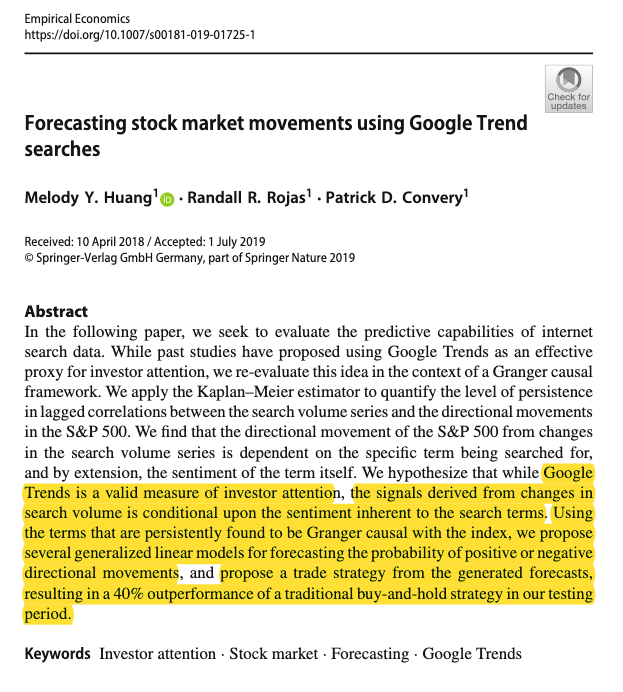

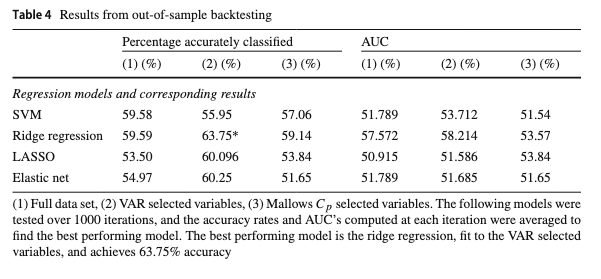

# Our models


## Feature Selection

> 1. All

> 2. Mean decrease impurity (random forest based) - MDI

> 3. Mean decrease accuracy (oos loss of performance; class based) - MDA

> 4. Single feature importance (oos individual feature; reg based) - SFI

> 5. Grenger causality - GRANGER

> 6. Granger causality + Logit - HUANG

> 7. Incremental association Markov boundary - IAMB

> 8. Max-Min Markov boundary - MMMB


## Prediction Models

> 1. Logit

> 2. Ridge regression

> 3. Lasso regression

> 4. Elastic net regression

> 5. Random Forest

> 6. Gradient Boosting

> 7. LSTM neural network (three layer)

## Prediction Setup

> 0. Sample from '2004-01-01' to '2020-12-31'

> 1. Feature selection: '2004-01-01' to '2012-07-03'

> 2. Forecasting: '2012-07-04' to '2020-12-31'

>> a. Random Search

>> b. Predict next year

>> c. Increase sample

# Aggregate prediction results

In [3]:
benchmarks = glob('data/indices/*.csv')
bench_list = []
for b in benchmarks:
    ticker = b.replace('data/indices/', '').replace('.csv', '')
    bench_ret_df = pd.read_csv(b)[3:]
    bench_ret_df.columns = ['date', 'return']
    bench_ret_df = bench_ret_df.melt('date')
    bench_ret_df['model'] = bench_ret_df['ticker'] = ticker
    bench_ret_df['fs'] = 'raw'

    bench_list.append(bench_ret_df)
benchmark_df = pd.concat(bench_list, axis=0)
benchmark_df['value'] = benchmark_df['value'].astype(float)

In [4]:
oos_melt_predictions_df, oos_melt_benchmark_df, oos_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                               fs_models=fs_methods,
                                                                                               evaluation_start_date=oos_start_date,
                                                                                               evaluation_end_date=oos_end_date,
                                                                                               ticker_names=tickers,
                                                                                               metric_name=metric,
                                                                                               tag='oos',
                                                                                               benchmark_name=benchmark_name)

/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src/prediction/functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['model'] = benchmark_df['ticker']
/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src/prediction/functions.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['fs'] = 'raw'


In [5]:
is_melt_predictions_df, is_melt_benchmark_df, is_melt_auc_df = aggregate_prediction_results(prediction_models=models,
                                                                                            fs_models=fs_methods,
                                                                                            evaluation_start_date='2005-01-03',
                                                                                            evaluation_end_date='2012-07-03',
                                                                                            ticker_names=tickers,
                                                                                            metric_name=metric,
                                                                                            tag='is',
                                                                                            benchmark_name=benchmark_name)

/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src/prediction/functions.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['model'] = benchmark_df['ticker']
/Users/danieloliveira/Documents/Daniel/codes/causal_feature/src/prediction/functions.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  benchmark_df['fs'] = 'raw'


## 1) AUC Analysis

### 1.1) In sample AUC median values

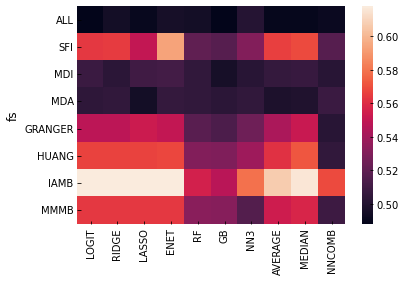

In [6]:
is_auc_df = is_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['isauc'], aggfunc='median')
simple_cols = [c[1] for c in is_auc_df.columns]
is_auc_df.columns = simple_cols
is_auc_df = is_auc_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.1) In sample AUC median values"))
display(HTML(is_auc_df.to_html()))
sns.heatmap(is_auc_df);

In [7]:
print((is_auc_df * 100).reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &   48.8 &   49.5 &   49.1 &  49.6 &  49.5 &  48.8 &  50.1 &     49.0 &    49.0 &    49.2 \\
     SFI &   56.4 &   56.5 &   55.0 &  59.4 &  52.0 &  51.7 &  53.1 &     56.6 &    56.9 &    51.7 \\
     MDI &   50.8 &   50.3 &   51.0 &  51.1 &  50.5 &  49.6 &  50.2 &     50.6 &    50.7 &    50.2 \\
     MDA &   50.4 &   50.5 &   49.5 &  50.6 &  50.5 &  50.3 &  50.5 &     49.8 &    49.9 &    50.8 \\
 GRANGER &   54.8 &   54.8 &   55.3 &  55.0 &  51.8 &  51.4 &  52.5 &     54.3 &    55.2 &    50.2 \\
   HUANG &   56.7 &   56.7 &   56.7 &  56.8 &  53.1 &  53.0 &  53.9 &     56.2 &    57.2 &    50.5 \\
    IAMB &   61.8 &   61.8 &   61.8 &  61.8 &  55.6 &  54.7 &  57.9 &     60.7 &    61.6 &    56.9 \\
    MMMB &   56.4 &   56.4 &   56.4 &  56.4 &  53.3 &  53.2 &  51.6 &     55.4 &    55.8 &    50.9 \\
\bottomrule
\end{tabular}



### 1.2) Out of sample AUC median values

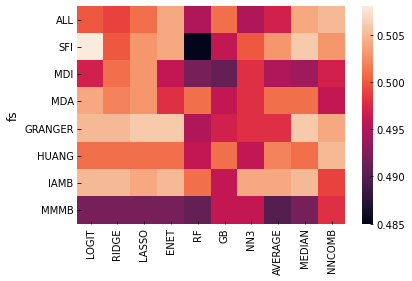

In [8]:
oos_auc_df = oos_melt_auc_df.pivot_table(index=['fs'], columns=['model'], values=['oosauc'], aggfunc='median')
simple_cols = [c[1] for c in oos_auc_df.columns]
oos_auc_df.columns = simple_cols
oos_auc_df = oos_auc_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.2) Out of sample AUC median values"))
display(HTML(oos_auc_df.to_html()))
sns.heatmap(oos_auc_df);

In [9]:
print((oos_auc_df * 100).reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &   50.0 &   49.9 &   50.1 &  50.4 &  49.5 &  50.1 &  49.5 &     49.7 &    50.4 &    50.5 \\
     SFI &   50.8 &   50.0 &   50.3 &  50.4 &  48.5 &  49.6 &  50.0 &     50.3 &    50.6 &    50.3 \\
     MDI &   49.7 &   50.1 &   50.3 &  49.6 &  49.2 &  49.1 &  49.8 &     49.5 &    49.4 &    49.7 \\
     MDA &   50.4 &   50.2 &   50.3 &  49.8 &  50.1 &  49.6 &  49.8 &     50.1 &    50.1 &    49.6 \\
 GRANGER &   50.5 &   50.5 &   50.6 &  50.6 &  49.5 &  49.7 &  49.8 &     49.8 &    50.6 &    50.4 \\
   HUANG &   50.1 &   50.1 &   50.1 &  50.1 &  49.6 &  50.1 &  49.6 &     50.2 &    50.1 &    50.5 \\
    IAMB &   50.5 &   50.5 &   50.4 &  50.5 &  50.1 &  49.6 &  50.4 &     50.4 &    50.5 &    49.9 \\
    MMMB &   49.2 &   49.2 &   49.2 &  49.2 &  49.1 &  49.6 &  49.6 &     49.0 &    49.2 &    49.8 \\
\bottomrule
\end{tabular}



### 1.3) Out of sample AUC distribution across forecasting models

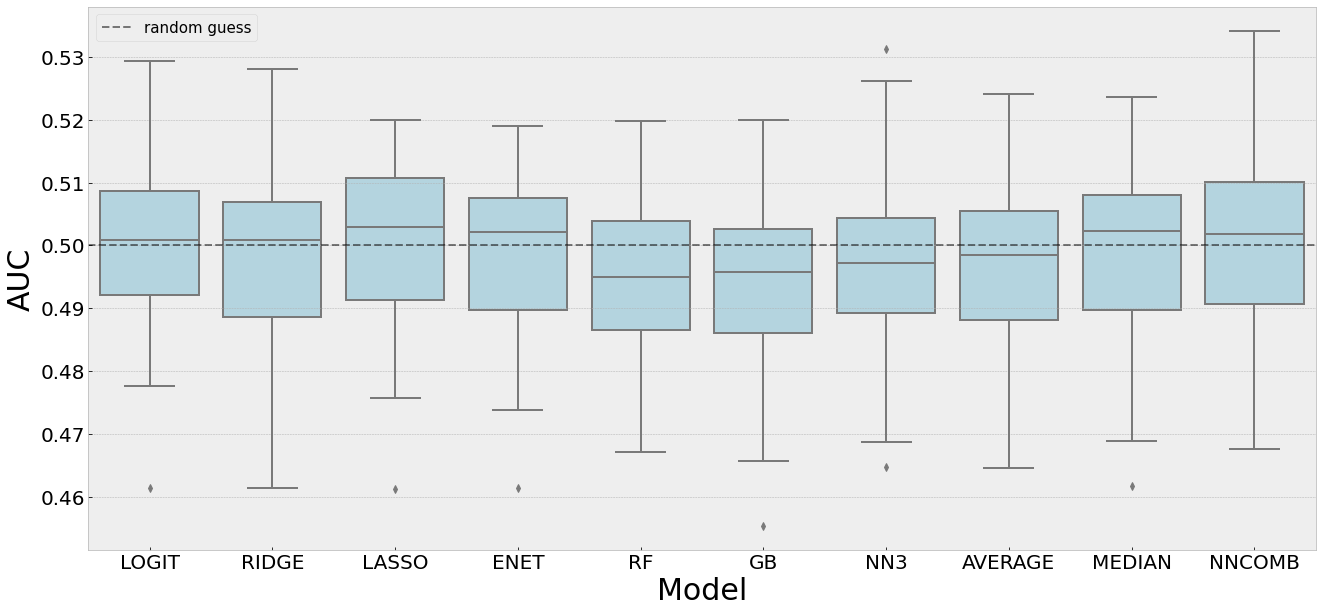

In [10]:
display(Markdown("### 1.3) Out of sample AUC distribution across forecasting models"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='oosauc',data=oos_melt_auc_df, ax=ax, order=models2, color='lightblue');
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_models_distr.png')

### 1.4) Out of sample AUC distribution across feature selection methods

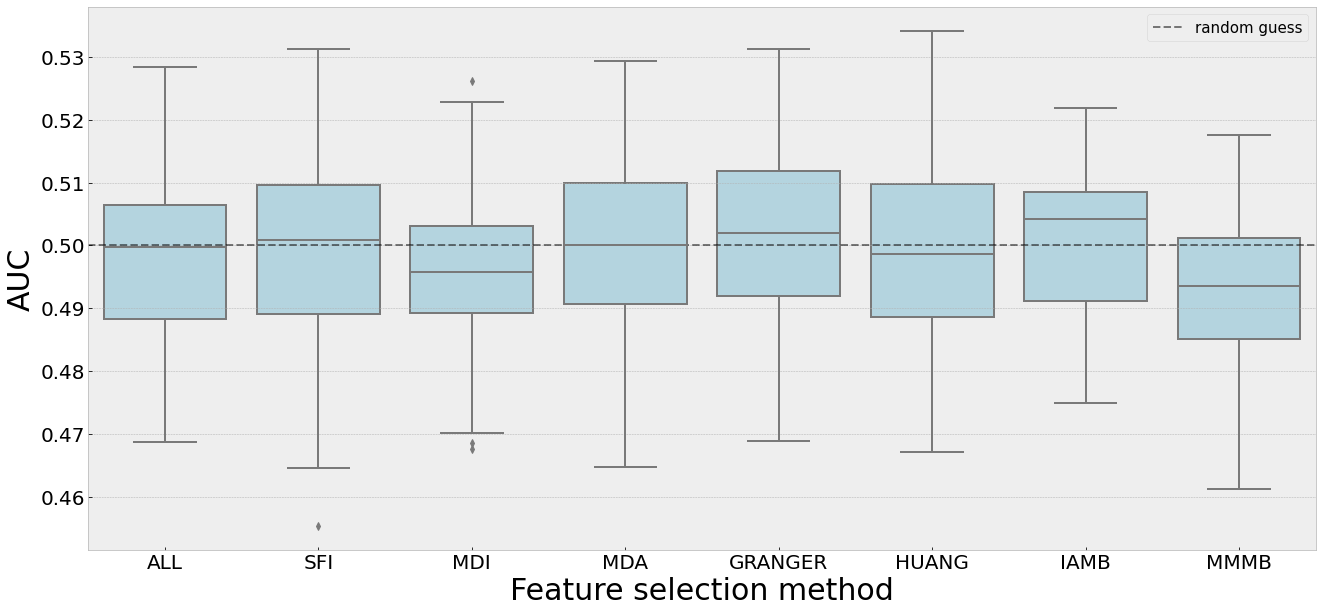

In [11]:
display(Markdown("### 1.4) Out of sample AUC distribution across feature selection methods"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='oosauc',data=oos_melt_auc_df, ax=ax, order=fs_methods2, color='lightblue');
ax.set_ylabel("AUC", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/oos_auc_fs_methods_distr.png')

In [12]:
tickers_to_analyze

['SPX Index', 'CCMP Index', 'RTY Index']

### 1.2) Out of sample AUC median values (SPX Index only)

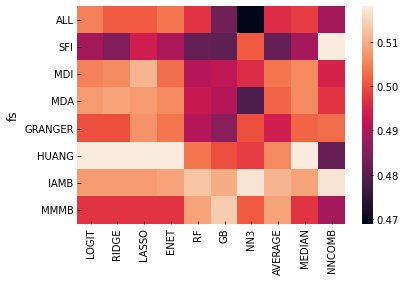

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &   50.5 &   50.1 &   50.1 &  50.4 &  49.7 &  48.3 &  46.9 &     49.6 &    49.8 &    48.9 \\
     SFI &   48.9 &   48.5 &   49.4 &  49.0 &  48.2 &  48.1 &  50.1 &     48.2 &    48.9 &    51.8 \\
     MDI &   50.5 &   50.6 &   51.1 &  50.3 &  49.1 &  49.2 &  49.6 &     50.4 &    50.6 &    49.5 \\
     MDA &   50.8 &   50.9 &   50.8 &  50.6 &  49.3 &  49.1 &  47.9 &     50.2 &    50.6 &    49.7 \\
 GRANGER &   50.0 &   50.0 &   50.7 &  50.4 &  49.1 &  48.6 &  50.0 &     49.4 &    50.2 &    50.3 \\
   HUANG &   51.8 &   51.8 &   51.8 &  51.8 &  50.4 &  50.0 &  49.8 &     50.6 &    51.8 &    48.2 \\
    IAMB &   50.8 &   50.8 &   50.8 &  50.9 &  51.3 &  51.0 &  51.7 &     51.1 &    50.9 &    51.7 \\
    MMMB &   49.7 &   49.7 &   49.7 &  49.7 &  50.9 &  51.4 &  50.1 &     50.9 &    49.7 &    48.9 \\
\bottomrule
\end{tabular}



### 1.5) Out of sample AUC distribution across forecasting models (SPX Index only)

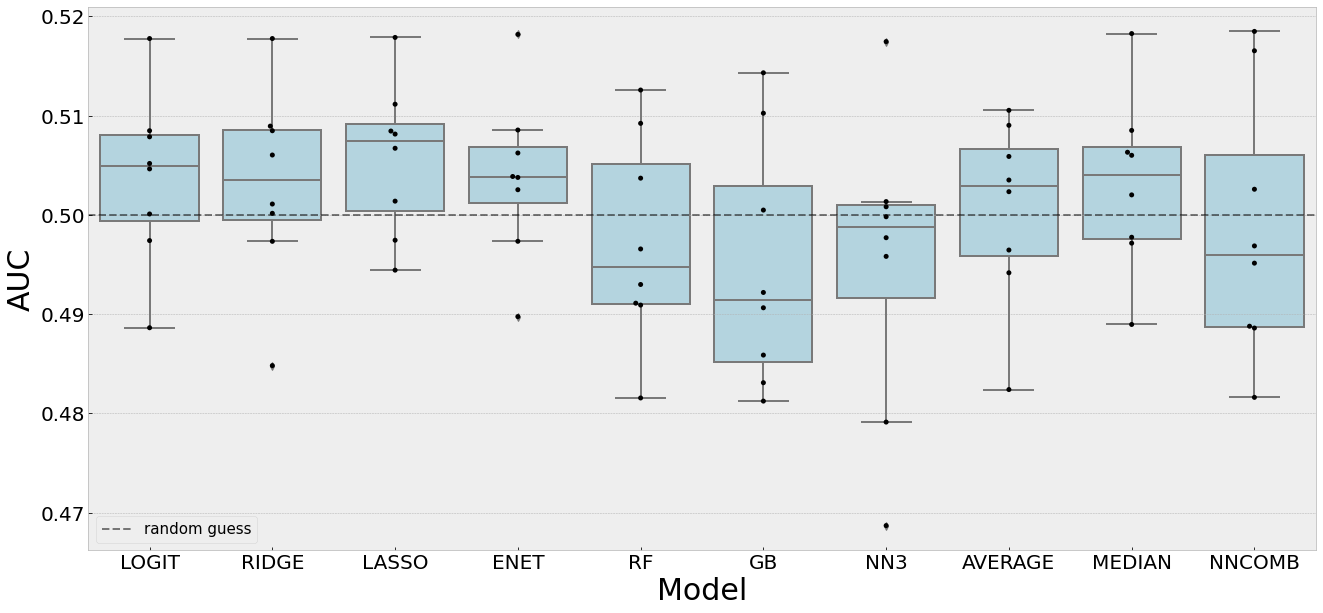

### 1.6) Out of sample AUC distribution across feature selection methods (SPX Index only)

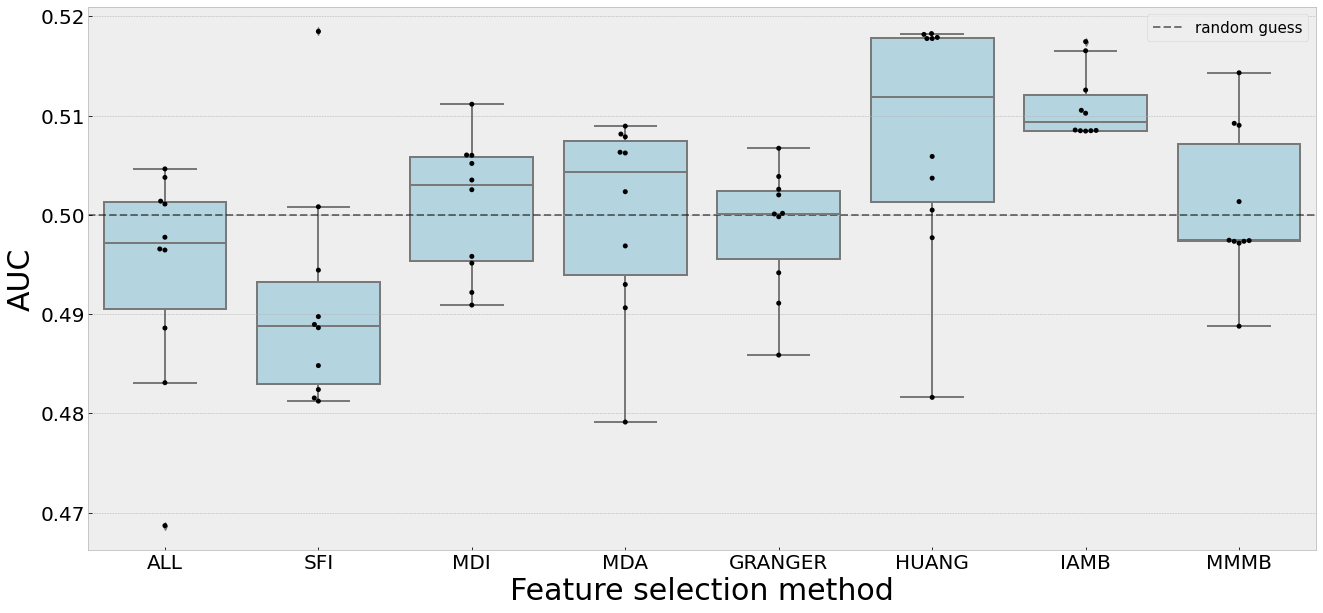

### 1.5) Out of sample AUC distribution across forecasting models (SPX Index only)

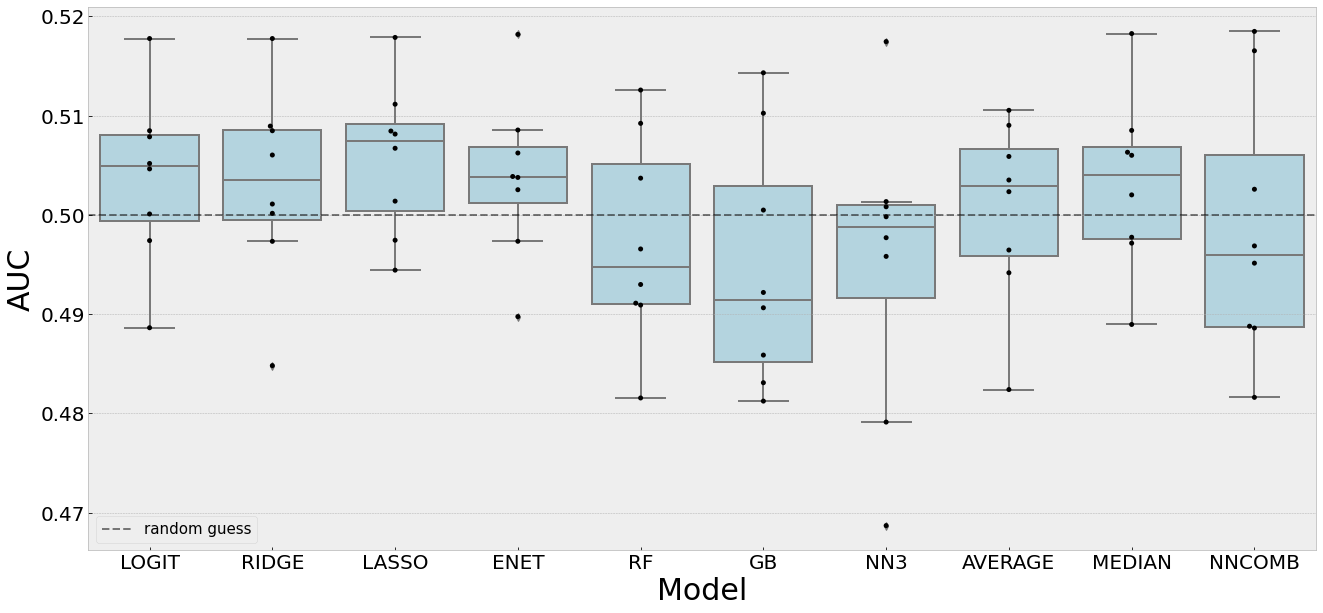

### 1.2) Out of sample AUC median values (CCMP Index only)

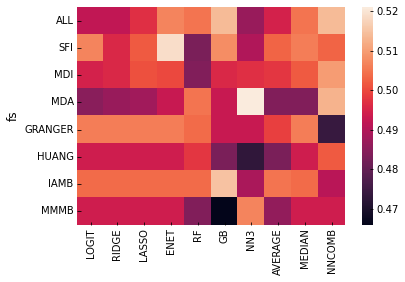

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &   49.2 &   49.2 &   49.7 &  50.7 &  50.5 &  51.4 &  48.7 &     49.5 &    50.5 &    51.4 \\
     SFI &   50.7 &   49.6 &   50.2 &  51.9 &  48.3 &  50.8 &  49.0 &     50.3 &    50.6 &    50.3 \\
     MDI &   49.5 &   49.6 &   50.1 &  50.0 &  48.4 &  49.6 &  49.7 &     49.8 &    50.2 &    51.0 \\
     MDA &   48.5 &   48.7 &   48.8 &  49.3 &  50.5 &  49.3 &  52.1 &     48.4 &    48.4 &    51.3 \\
 GRANGER &   50.6 &   50.6 &   50.6 &  50.6 &  50.4 &  49.3 &  49.3 &     49.9 &    50.6 &    47.4 \\
   HUANG &   49.4 &   49.4 &   49.4 &  49.4 &  49.8 &  48.3 &  47.3 &     48.3 &    49.4 &    50.2 \\
    IAMB &   50.4 &   50.4 &   50.4 &  50.4 &  50.4 &  51.5 &  48.9 &     50.5 &    50.4 &    49.1 \\
    MMMB &   49.4 &   49.4 &   49.4 &  49.4 &  48.4 &  46.6 &  50.7 &     48.6 &    49.4 &    49.4 \\
\bottomrule
\end{tabular}



### 1.5) Out of sample AUC distribution across forecasting models (CCMP Index only)

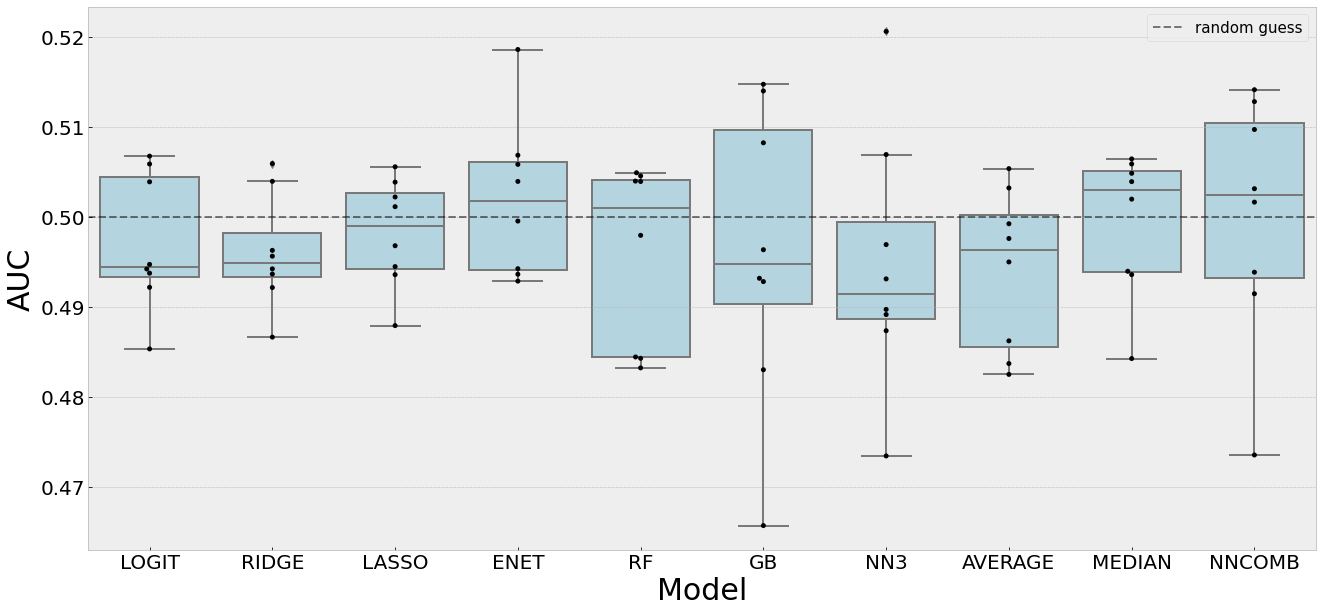

### 1.6) Out of sample AUC distribution across feature selection methods (CCMP Index only)

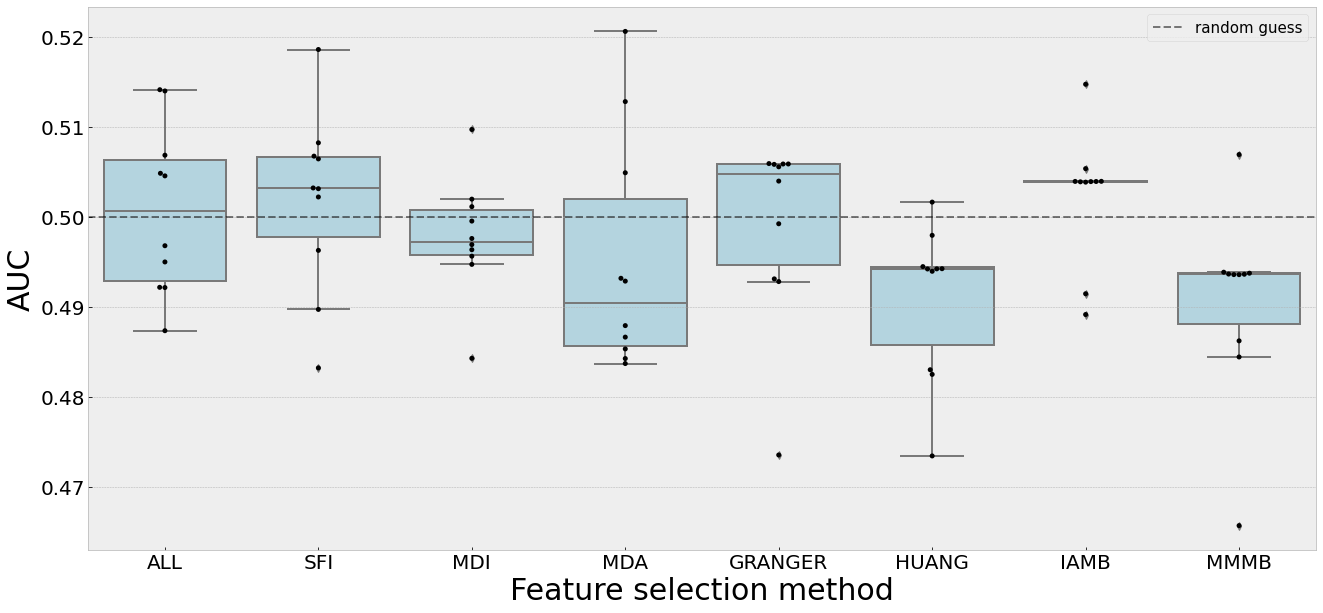

### 1.5) Out of sample AUC distribution across forecasting models (CCMP Index only)

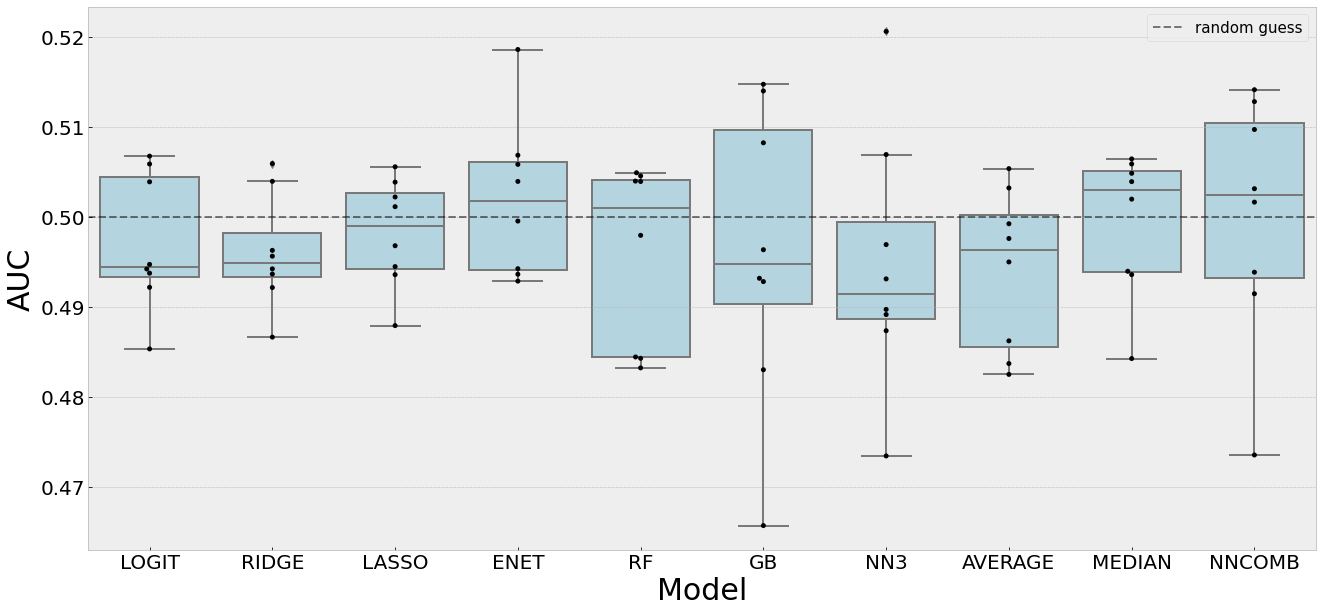

### 1.2) Out of sample AUC median values (RTY Index only)

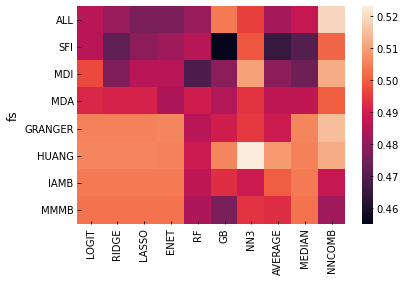

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &   48.6 &   48.1 &   47.6 &  47.6 &  48.1 &  50.4 &  49.6 &     48.3 &    48.8 &    51.9 \\
     SFI &   48.6 &   47.2 &   47.9 &  48.2 &  48.6 &  45.5 &  49.9 &     46.5 &    47.0 &    50.1 \\
     MDI &   49.7 &   47.7 &   48.6 &  48.6 &  46.9 &  47.9 &  51.0 &     47.9 &    47.4 &    51.2 \\
     MDA &   49.2 &   49.1 &   49.1 &  48.4 &  49.0 &  48.5 &  49.4 &     48.7 &    48.7 &    50.0 \\
 GRANGER &   50.5 &   50.5 &   50.5 &  50.6 &  48.6 &  49.0 &  49.5 &     48.9 &    50.6 &    51.5 \\
   HUANG &   50.6 &   50.6 &   50.6 &  50.5 &  48.9 &  50.6 &  52.3 &     50.9 &    50.5 &    51.2 \\
    IAMB &   50.4 &   50.4 &   50.4 &  50.4 &  48.7 &  49.3 &  48.9 &     50.0 &    50.4 &    48.8 \\
    MMMB &   50.3 &   50.3 &   50.3 &  50.3 &  48.4 &  47.6 &  49.4 &     49.3 &    50.3 &    48.2 \\
\bottomrule
\end{tabular}



### 1.5) Out of sample AUC distribution across forecasting models (RTY Index only)

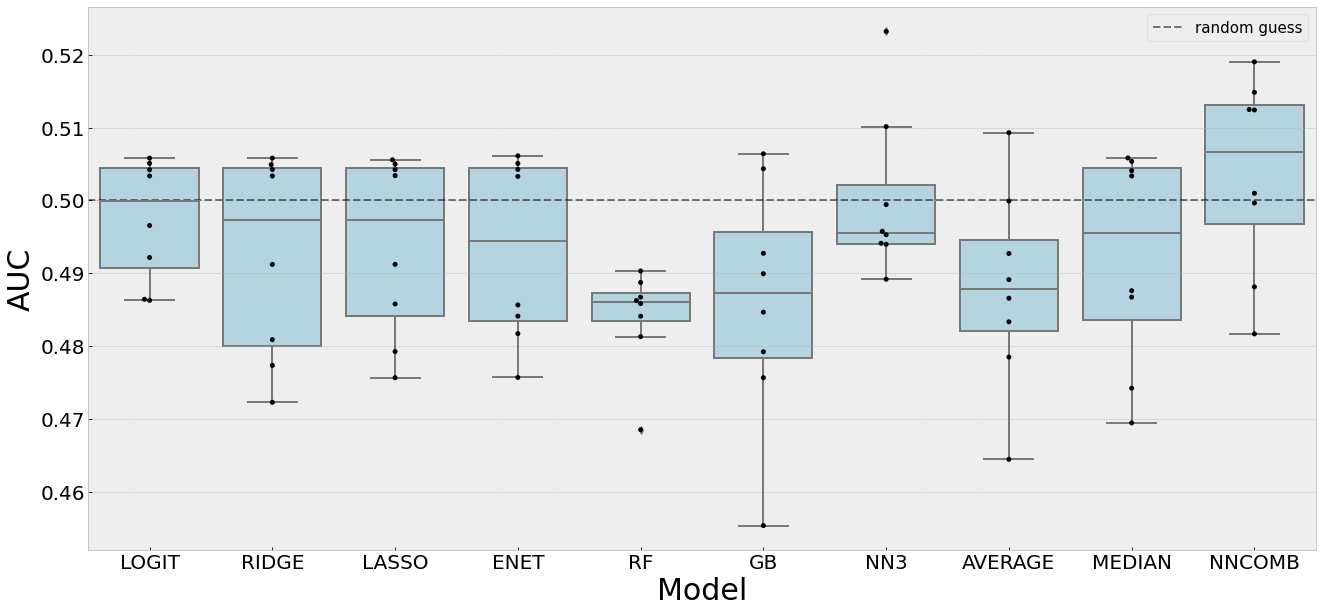

### 1.6) Out of sample AUC distribution across feature selection methods (RTY Index only)

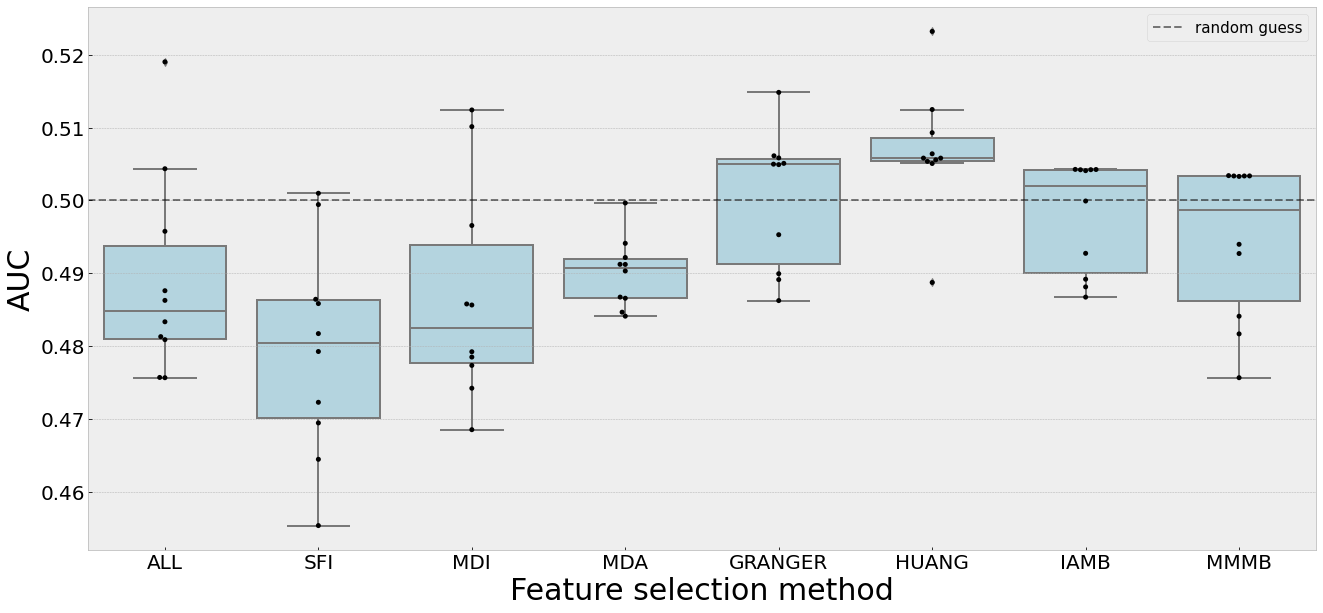

### 1.5) Out of sample AUC distribution across forecasting models (RTY Index only)

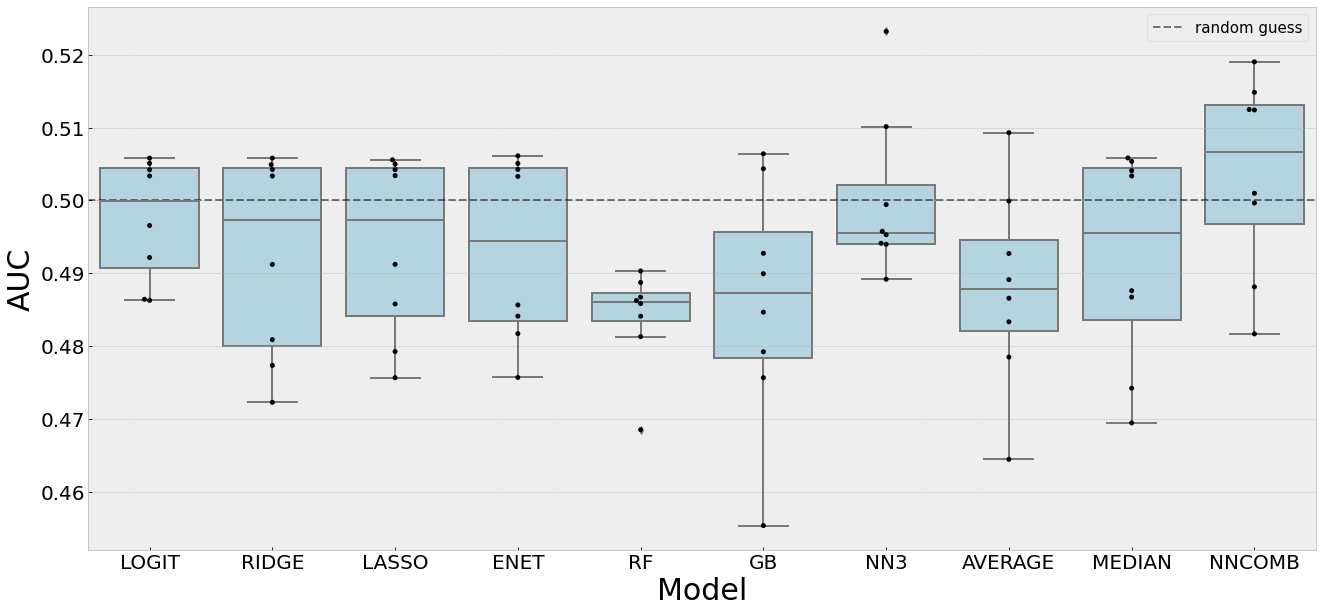

In [13]:
for ts in tickers_to_analyze:
    oos_spx_auc_df = oos_melt_auc_df[oos_melt_auc_df["ticker"] == ts].reset_index(drop=True)

    oos_spx_auc_df1 = oos_spx_auc_df.copy()
    oos_spx_auc_df1 = oos_spx_auc_df.pivot_table(index=['fs'], columns=['model'], values=['oosauc'], aggfunc='median')
    simple_cols = [c[1] for c in oos_spx_auc_df1.columns]
    oos_spx_auc_df1.columns = simple_cols
    oos_spx_auc_df1 = oos_spx_auc_df1.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

    display(Markdown("### 1.2) Out of sample AUC median values (" + ts + " only)"))
    display(HTML(oos_spx_auc_df1.to_html()))
    sns.heatmap(oos_spx_auc_df1);
    plt.show()
    
    print((oos_spx_auc_df1 * 100).reset_index().to_latex(index=False))

    display(Markdown("### 1.5) Out of sample AUC distribution across forecasting models (" + ts + " only)"))

    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="model", y='oosauc',
                data=oos_spx_auc_df, ax=ax, order=models2, color='lightblue');
    sns.swarmplot(x="model", y='oosauc',
                  data=oos_spx_auc_df,ax=ax,
                  color="k",order=models2)

    ax.set_ylabel("AUC", fontsize=30);
    ax.set_xlabel("Model", fontsize=30);
    ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_auc_models_distr_" + ts.split(" ")[0].lower() + ".png")

    display(Markdown("### 1.6) Out of sample AUC distribution across feature selection methods (" + ts + " only)"))

    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="fs", y='oosauc',data=oos_spx_auc_df, ax=ax, order=fs_methods2, color='lightblue');
    sns.swarmplot(x="fs", y='oosauc',
                  data=oos_spx_auc_df,ax=ax,
                  color="k",order=fs_methods2)
    ax.set_ylabel("AUC", fontsize=30);
    ax.set_xlabel("Feature selection method", fontsize=30);
    ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_auc_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")

    display(Markdown("### 1.5) Out of sample AUC distribution across forecasting models (" + ts + " only)"))

    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="model", y='oosauc',
                data=oos_spx_auc_df, ax=ax, order=models2, color='lightblue');
    sns.swarmplot(x="model", y='oosauc',
                  data=oos_spx_auc_df,ax=ax,
                  color="k",order=models2)

    ax.set_ylabel("AUC", fontsize=30);
    ax.set_xlabel("Model", fontsize=30);
    ax.axhline(y=0.50, color='k', linestyle='--', alpha=0.5, label="random guess");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_auc_models_distr_" + ts.split(" ")[0].lower() + ".png")


In [14]:
oos_pred_ret_df, oos_pred_pos_df = gen_strat_positions_and_ret_from_pred(predictions_df=oos_melt_predictions_df,
                                                                         class_threshold=0.5,
                                                                         target_asset_returns=benchmark_df)

ret_all_df = pd.concat([oos_pred_ret_df, benchmark_df], axis=0)

oos_benchmark_df = benchmark_df.loc[(benchmark_df['date'])>= oos_start_date]
pivot_oos_benchmark_df = oos_benchmark_df.pivot_table(index=['date'], columns=['model'], values=['value']).dropna()
pivot_oos_benchmark_df.columns = pivot_oos_benchmark_df.columns.droplevel()
pivot_oos_benchmark_df['Combined portfolio'] = pivot_oos_benchmark_df.mean(axis=1)

ann_avg_ret_benchmark = (pivot_oos_benchmark_df.mean() * 252).reset_index()
ann_avg_ret_benchmark.columns = ['ticker', 'Ann. Avg. Return']
# ann_avg_ret = ann_avg_ret_benchmark.loc[ann_avg_ret_benchmark['ticker'] == 'Combined portfolio']['Ann Avg Return'].iloc[0]

ann_vol_benchmark = (pivot_oos_benchmark_df.std() * np.sqrt(252)).reset_index()
ann_vol_benchmark.columns = ['ticker', 'Ann. Volatility']
# ann_vol_ret = ann_vol_benchmark.loc[ann_vol_benchmark['ticker'] == 'Combined portfolio']['Ann Volatility'].iloc[0]

sr_benchmark = (pivot_oos_benchmark_df.mean() / pivot_oos_benchmark_df.std() * np.sqrt(252)).reset_index()
sr_benchmark.columns = ['ticker', 'Sharpe ratio']
# average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == 'Combined portfolio']['sharpe ratio'].iloc[0]

cum_prod_df = (1 + pivot_oos_benchmark_df / 100).cumprod()
previous_peaks_df = cum_prod_df.cummax()
mdd_benchmark = (cum_prod_df - previous_peaks_df) / previous_peaks_df
mdd_benchmark = pd.DataFrame(mdd_benchmark.min().sort_values(ascending=False) * 100).reset_index()
mdd_benchmark.columns = ['ticker', 'Max. drawdown']
# average_mdd = mdd_df.loc[mdd_df['ticker'] == 'Combined portfolio']['max drawdown'].iloc[0]

ann_avg_ret_benchmark.set_index('ticker', inplace=True)
mdd_benchmark.set_index('ticker', inplace=True)
cr_benchmark = pd.merge(ann_avg_ret_benchmark, mdd_benchmark, right_index=True, left_index=True)
cr_benchmark['Calmar ratio'] = (ann_avg_ret_benchmark['Ann. Avg. Return'] / 100) / ((mdd_benchmark['Max. drawdown'] * -1) / 100)
cr_benchmark = cr_benchmark[['Calmar ratio']]
cr_benchmark = cr_benchmark.reset_index()

## 1) Sharpe ratio - Combined portfolio

### 1.1) Out of sample Ann. Sharpe ratio median values (Combined portfolio average benchmark 0.859)

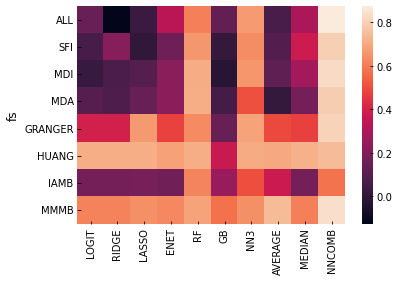

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &   0.14 &  -0.13 &   0.03 &  0.33 &  0.60 &  0.13 &  0.67 &     0.07 &    0.29 &    0.87 \\
     SFI &   0.06 &   0.21 &   0.01 &  0.16 &  0.66 &  0.01 &  0.64 &     0.09 &    0.38 &    0.80 \\
     MDI &   0.02 &   0.07 &   0.10 &  0.22 &  0.71 & -0.02 &  0.66 &     0.12 &    0.28 &    0.83 \\
     MDA &   0.10 &   0.08 &   0.14 &  0.23 &  0.71 &  0.05 &  0.51 &     0.01 &    0.17 &    0.79 \\
 GRANGER &   0.40 &   0.40 &   0.66 &  0.48 &  0.64 &  0.14 &  0.69 &     0.49 &    0.48 &    0.81 \\
   HUANG &   0.72 &   0.72 &   0.71 &  0.68 &  0.72 &  0.37 &  0.71 &     0.71 &    0.72 &    0.75 \\
    IAMB &   0.17 &   0.17 &   0.18 &  0.16 &  0.62 &  0.26 &  0.50 &     0.37 &    0.17 &    0.58 \\
    MMMB &   0.62 &   0.62 &   0.64 &  0.62 &  0.69 &  0.57 &  0.64 &     0.75 &    0.61 &    0.84 \\
\bottomrule
\end{tabular}



### 1.2) Out of sample Ann. Sharpe ratio distribution across forecasting models (Combined portfolio only)

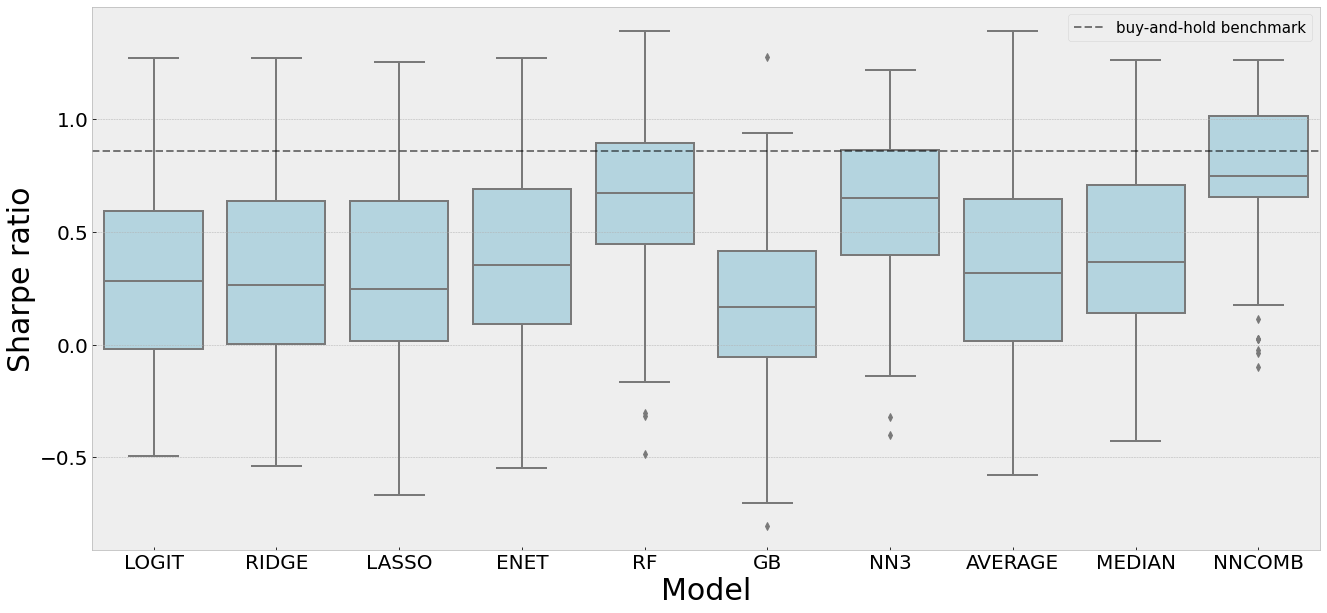

### 1.3) Out of sample Ann. Sharpe ratio distribution across feature selection methods (Combined portfolio only)

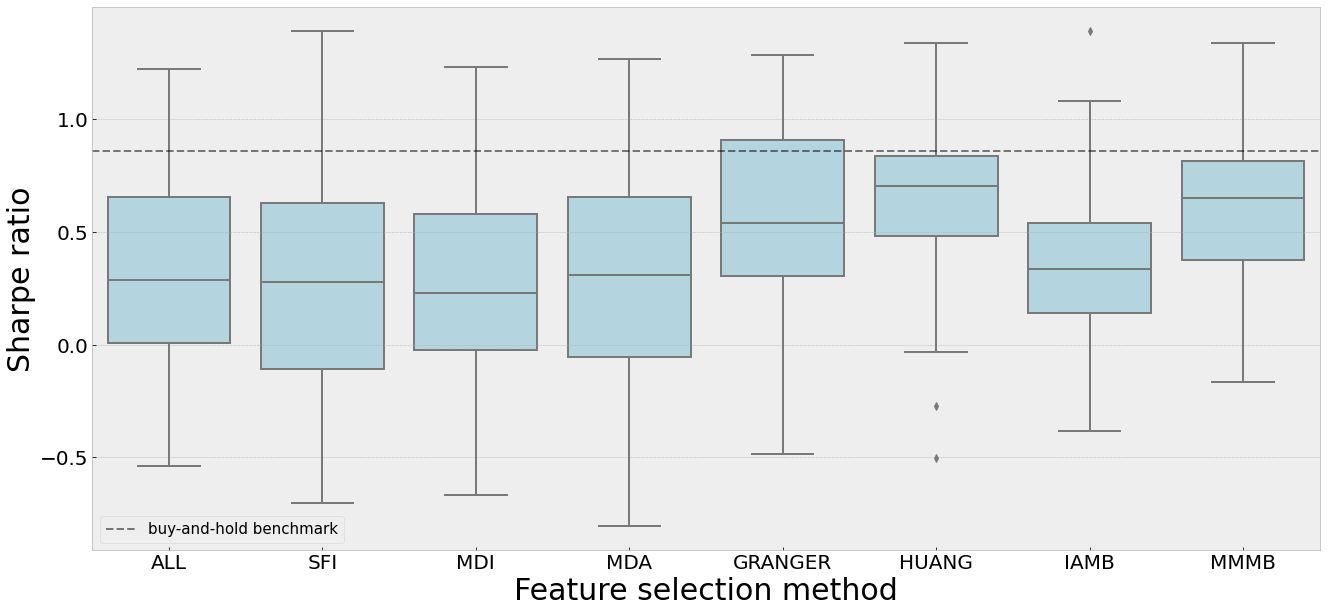

## 2) Calmar ratio - Combined portfolio

### 2.1) Out of sample Ann. Calmar ratio median values (Combined portfolio average benchmark 0.408)

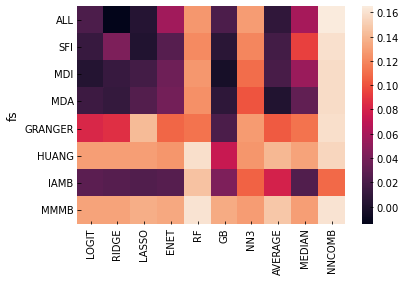

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &   0.02 &  -0.01 &   0.00 &  0.06 &  0.13 &  0.02 &  0.13 &     0.01 &    0.06 &    0.16 \\
     SFI &   0.01 &   0.04 &   0.00 &  0.03 &  0.12 &  0.01 &  0.12 &     0.02 &    0.09 &    0.16 \\
     MDI &   0.00 &   0.01 &   0.02 &  0.04 &  0.13 & -0.00 &  0.11 &     0.02 &    0.06 &    0.16 \\
     MDA &   0.02 &   0.01 &   0.02 &  0.04 &  0.12 &  0.01 &  0.10 &     0.00 &    0.03 &    0.16 \\
 GRANGER &   0.08 &   0.09 &   0.14 &  0.11 &  0.11 &  0.02 &  0.13 &     0.10 &    0.11 &    0.16 \\
   HUANG &   0.13 &   0.13 &   0.13 &  0.13 &  0.16 &  0.07 &  0.13 &     0.14 &    0.13 &    0.16 \\
    IAMB &   0.03 &   0.03 &   0.02 &  0.03 &  0.15 &  0.04 &  0.11 &     0.08 &    0.02 &    0.11 \\
    MMMB &   0.13 &   0.13 &   0.14 &  0.13 &  0.16 &  0.14 &  0.13 &     0.15 &    0.13 &    0.16 \\
\bottomrule
\end{tabular}



### 2.2) Out of sample Ann. Calmar ratio distribution across forecasting models (Combined portfolio only)

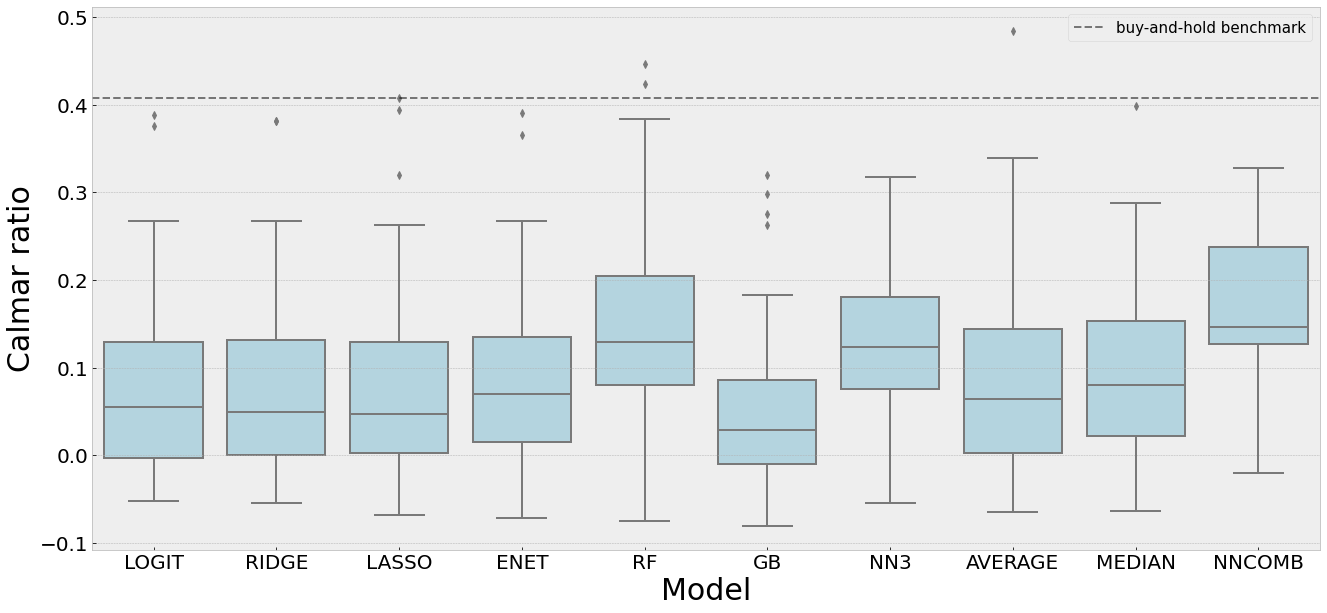

### 2.3) Out of sample Ann. Calmar ratio distribution across feature selection methods (Combined portfolio only)

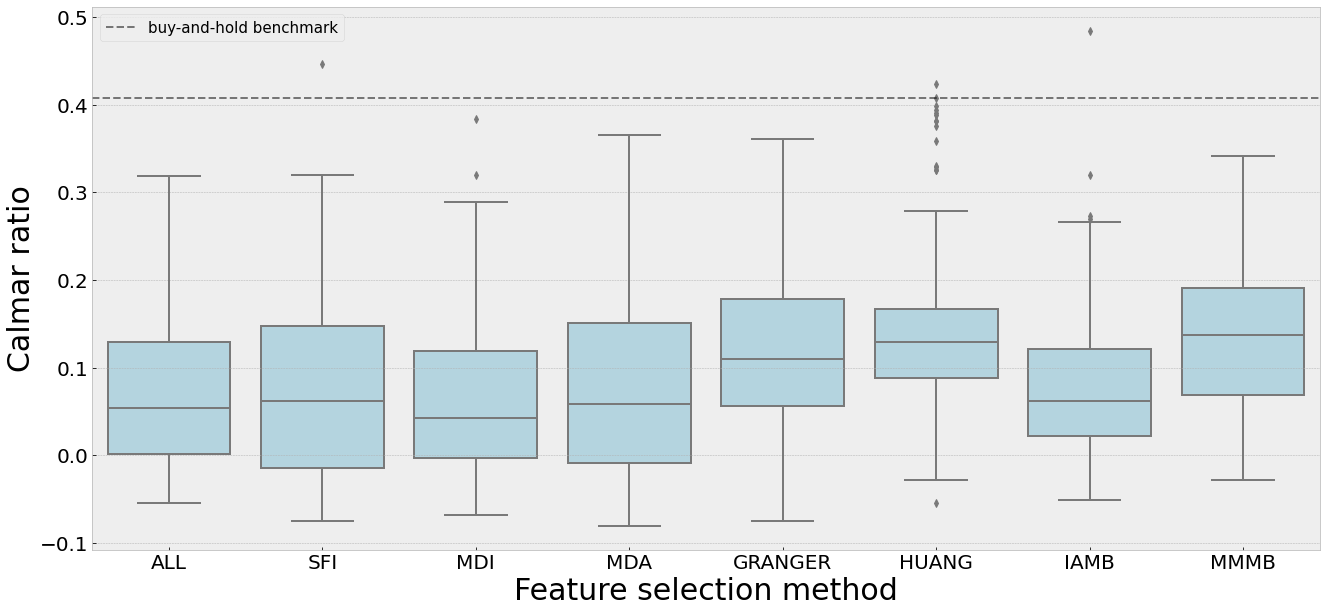

In [15]:
ts = "Combined portfolio"

display(Markdown("## 1) Sharpe ratio - " + ts))
average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == ts]['Sharpe ratio'].iloc[0]
sr_rank_df, sr_tb_df, sr_agg_df = sharpe_ratio_tb(returns_df=ret_all_df.dropna(),
                                                  level_to_subset='fs',
                                                  rf=.0)
sr_df = sr_rank_df.reset_index()
sr_df_raw = sr_df.loc[sr_df["fs"]=="raw"].reset_index(drop=True)
sr_df = sr_df.loc[sr_df["fs"]!="raw"].reset_index(drop=True)
sr_df_spx = sr_df.loc[sr_df["ticker"]==ts].reset_index(drop=True)

# Sanity Check
assert oos_melt_auc_df.shape[0] == sr_df.shape[0]

simple_sr_df = sr_df.pivot_table(index=['fs'], columns=['model'], values=['Sharpe ratio'], aggfunc='median')
simple_cols = [c[1] for c in simple_sr_df.columns]
simple_sr_df.columns = simple_cols
simple_sr_df = simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 1.1) Out of sample Ann. Sharpe ratio median values (" + ts + " average benchmark {:.3f})".format(average_sr)))
display(HTML(simple_sr_df.to_html()))
sns.heatmap(simple_sr_df);
plt.show()
print((simple_sr_df.apply(lambda x: np.round(x,2))).reset_index().to_latex(index=False))

display(Markdown("### 1.2) Out of sample Ann. Sharpe ratio distribution across forecasting models (" + ts + " only)"))
fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='Sharpe ratio', data=sr_df, ax=ax, order=models2, color='lightblue');
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_sr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
plt.show()
fig.savefig("img/oos_sr_models_distr_" + ts.split(" ")[0].lower() + ".png")

display(Markdown("### 1.3) Out of sample Ann. Sharpe ratio distribution across feature selection methods (" + ts + " only)"))
fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='Sharpe ratio',data=sr_df, ax=ax, order=fs_methods2, color='lightblue');
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=average_sr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
plt.show()
fig.savefig("img/oos_sr_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")

display(Markdown("## 2) Calmar ratio - " + ts))
average_cr = cr_benchmark.loc[cr_benchmark['ticker'] == ts]['Calmar ratio'].iloc[0]
cr_rank_df, cr_tb_df, cr_agg_df = calmar_ratio_tb(returns_df=ret_all_df.dropna(),
                                                  level_to_subset='fs')
cr_df = cr_rank_df.reset_index()
cr_df_raw = cr_df.loc[cr_df["fs"]=="raw"].reset_index(drop=True)
cr_df = cr_df.loc[cr_df["fs"]!="raw"].reset_index(drop=True)
cr_df_spx = cr_df.loc[cr_df["ticker"]==ts].reset_index(drop=True)

# Sanity Check
assert oos_melt_auc_df.shape[0] == cr_df.shape[0]

simple_cr_df = cr_df.pivot_table(index=['fs'], columns=['model'], values=['Calmar ratio'], aggfunc='median')
simple_cols = [c[1] for c in simple_cr_df.columns]
simple_cr_df.columns = simple_cols
simple_cr_df = simple_cr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

display(Markdown("### 2.1) Out of sample Ann. Calmar ratio median values (" + ts + " average benchmark {:.3f})".format(average_cr)))
display(HTML(simple_cr_df.to_html()))
sns.heatmap(simple_cr_df);
plt.show()
print((simple_cr_df.apply(lambda x: np.round(x,2))).reset_index().to_latex(index=False))

display(Markdown("### 2.2) Out of sample Ann. Calmar ratio distribution across forecasting models (" + ts + " only)"))
fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="model", y='Calmar ratio', data=cr_df, ax=ax, order=models2, color='lightblue');
ax.set_ylabel("Calmar ratio", fontsize=30);
ax.set_xlabel("Model", fontsize=30);
ax.axhline(y=average_cr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
plt.show()
fig.savefig("img/oos_cr_models_distr_" + ts.split(" ")[0].lower() + ".png")

display(Markdown("### 2.3) Out of sample Ann. Calmar ratio distribution across feature selection methods (" + ts + " only)"))
fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="fs", y='Calmar ratio',data=cr_df, ax=ax, order=fs_methods2, color='lightblue');
ax.set_ylabel("Calmar ratio", fontsize=30);
ax.set_xlabel("Feature selection method", fontsize=30);
ax.axhline(y=average_cr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
plt.show()
fig.savefig("img/oos_cr_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")

## 1) Sharpe ratio - SPX Index

### 1.1) Out of sample Ann. Sharpe ratio median values (SPX Index average benchmark 0.914)

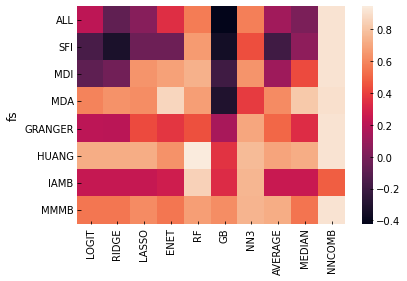

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &   0.22 &  -0.08 &   0.05 &  0.34 &  0.57 & -0.42 &  0.58 &     0.13 &    0.01 &    0.91 \\
     SFI &  -0.16 &  -0.32 &  -0.04 & -0.04 &  0.67 & -0.35 &  0.44 &    -0.19 &    0.07 &    0.92 \\
     MDI &  -0.09 &  -0.02 &   0.64 &  0.69 &  0.74 & -0.20 &  0.64 &     0.11 &    0.43 &    0.91 \\
     MDA &   0.59 &   0.64 &   0.62 &  0.87 &  0.68 & -0.31 &  0.39 &     0.62 &    0.82 &    0.90 \\
 GRANGER &   0.21 &   0.21 &   0.43 &  0.37 &  0.45 &  0.15 &  0.70 &     0.51 &    0.34 &    0.91 \\
   HUANG &   0.73 &   0.73 &   0.72 &  0.64 &  0.95 &  0.36 &  0.77 &     0.70 &    0.72 &    0.92 \\
    IAMB &   0.24 &   0.24 &   0.24 &  0.28 &  0.85 &  0.33 &  0.76 &     0.26 &    0.25 &    0.48 \\
    MMMB &   0.56 &   0.56 &   0.62 &  0.56 &  0.68 &  0.62 &  0.75 &     0.72 &    0.55 &    0.91 \\
\bottomrule
\end{tabular}



### 1.2) Out of sample Ann. Sharpe ratio distribution across forecasting models (SPX Index only)

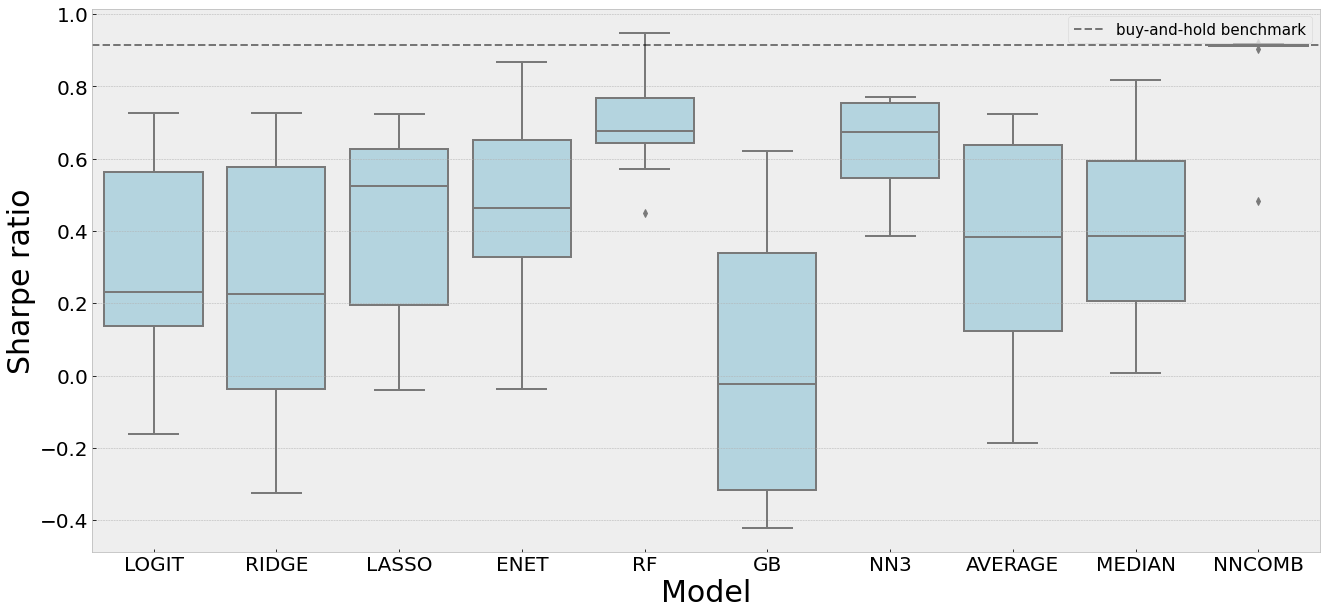

### 1.3) Out of sample Ann. Sharpe ratio distribution across feature selection methods (SPX Index only)

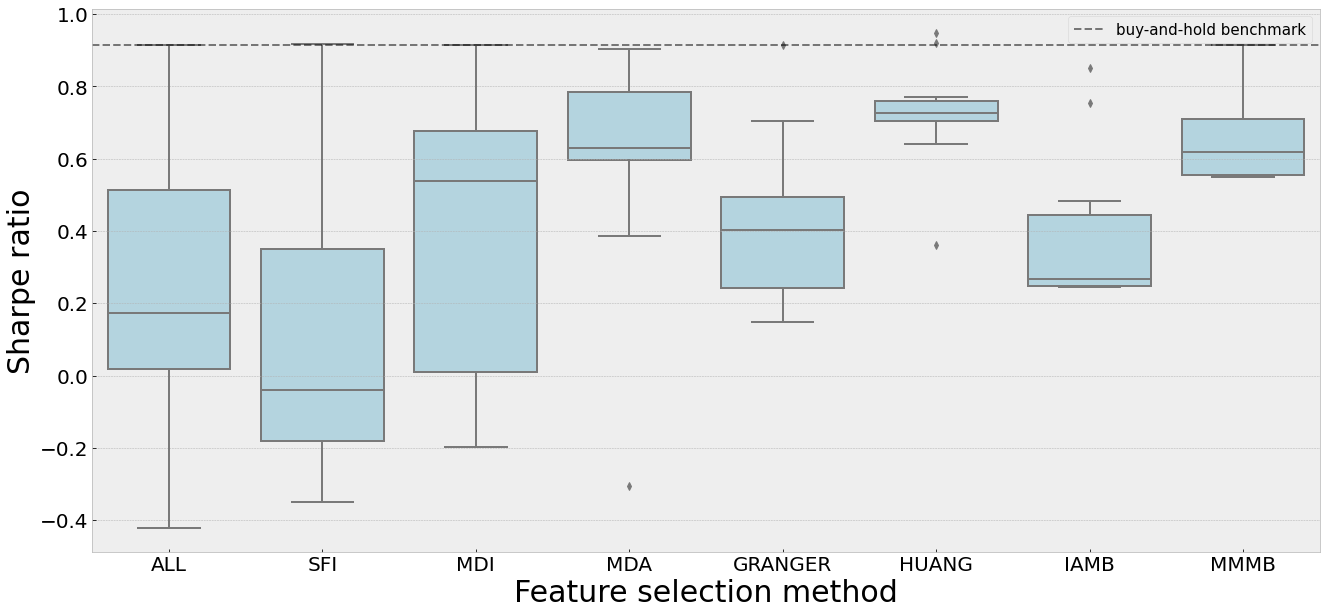

## 2) Calmar ratio - SPX Index

### 2.1) Out of sample Ann. Calmar ratio median values (SPX Index average benchmark 0.456)

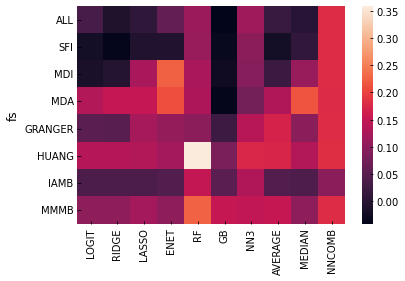

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &   0.03 &  -0.01 &   0.01 &  0.06 &  0.11 & -0.04 &  0.12 &     0.02 &    0.00 &    0.18 \\
     SFI &  -0.02 &  -0.04 &  -0.01 & -0.01 &  0.11 & -0.03 &  0.10 &    -0.02 &    0.01 &    0.18 \\
     MDI &  -0.01 &  -0.00 &   0.12 &  0.22 &  0.12 & -0.02 &  0.09 &     0.02 &    0.11 &    0.18 \\
     MDA &   0.13 &   0.15 &   0.15 &  0.21 &  0.13 & -0.04 &  0.08 &     0.13 &    0.22 &    0.18 \\
 GRANGER &   0.05 &   0.05 &   0.12 &  0.11 &  0.10 &  0.02 &  0.14 &     0.17 &    0.10 &    0.18 \\
   HUANG &   0.14 &   0.14 &   0.14 &  0.12 &  0.36 &  0.08 &  0.18 &     0.17 &    0.14 &    0.18 \\
    IAMB &   0.04 &   0.04 &   0.04 &  0.04 &  0.15 &  0.05 &  0.13 &     0.04 &    0.04 &    0.10 \\
    MMMB &   0.10 &   0.10 &   0.12 &  0.10 &  0.23 &  0.15 &  0.15 &     0.15 &    0.10 &    0.18 \\
\bottomrule
\end{tabular}



### 2.2) Out of sample Ann. Calmar ratio distribution across forecasting models (SPX Index only)

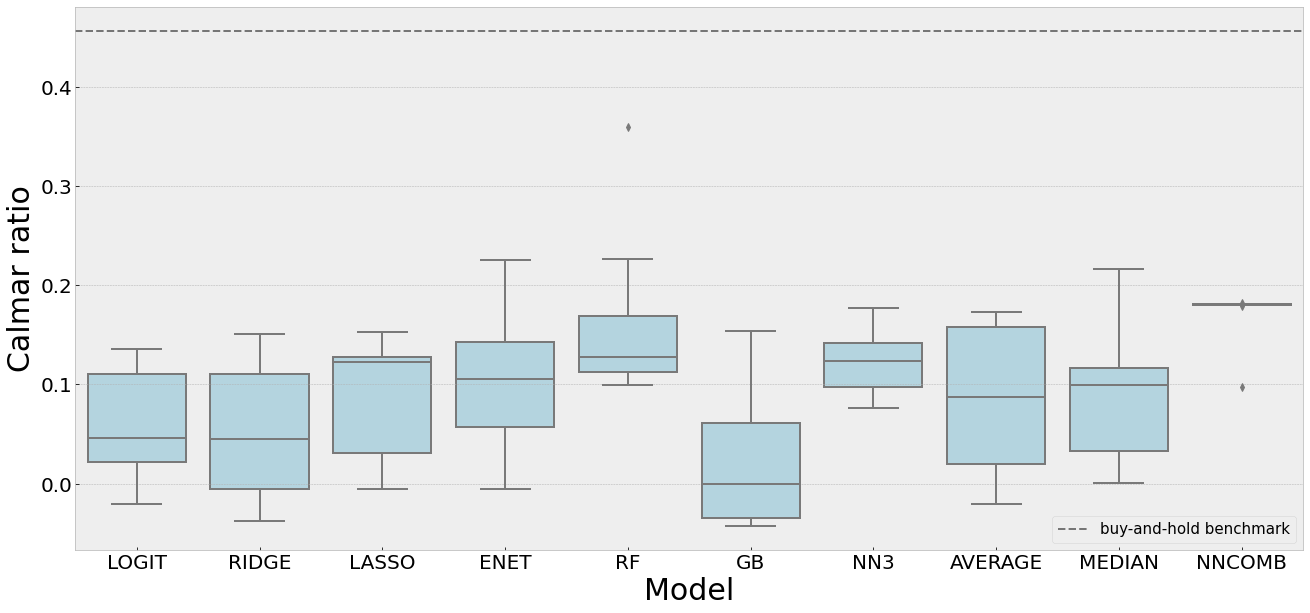

### 2.3) Out of sample Ann. Calmar ratio distribution across feature selection methods (SPX Index only)

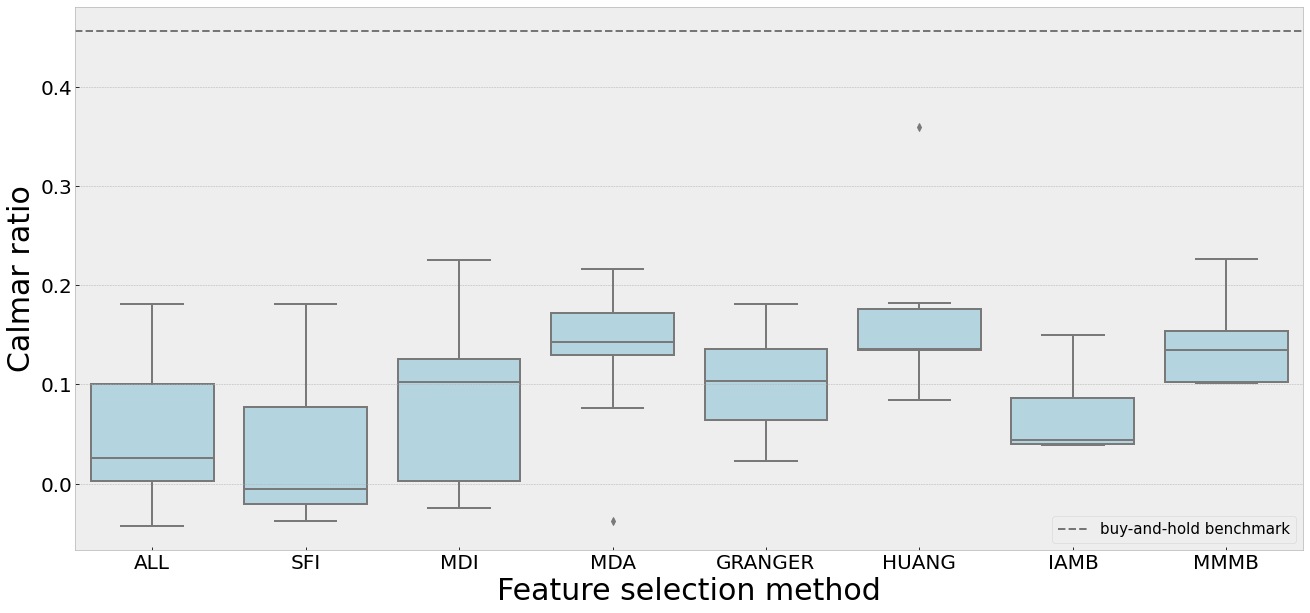

## 1) Sharpe ratio - CCMP Index

### 1.1) Out of sample Ann. Sharpe ratio median values (CCMP Index average benchmark 1.083)

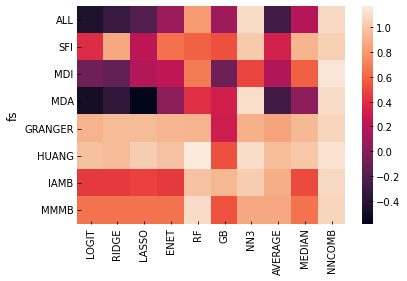

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &  -0.45 &  -0.32 &  -0.21 &  0.10 &  0.81 &  0.11 &  1.09 &    -0.27 &    0.20 &    1.08 \\
     SFI &   0.39 &   0.86 &   0.24 &  0.64 &  0.59 &  0.53 &  1.01 &     0.33 &    0.92 &    1.03 \\
     MDI &  -0.09 &  -0.14 &   0.19 &  0.24 &  0.68 & -0.10 &  0.49 &     0.17 &    0.58 &    1.14 \\
     MDA &  -0.49 &  -0.35 &  -0.58 &  0.03 &  0.40 &  0.32 &  1.11 &    -0.28 &    0.04 &    1.10 \\
 GRANGER &   0.91 &   0.95 &   0.94 &  0.92 &  0.92 &  0.31 &  0.91 &     0.85 &    0.94 &    1.07 \\
   HUANG &   0.98 &   0.96 &   1.02 &  0.98 &  1.17 &  0.53 &  1.10 &     0.96 &    1.00 &    1.12 \\
    IAMB &   0.44 &   0.44 &   0.48 &  0.44 &  0.98 &  0.93 &  1.03 &     0.89 &    0.51 &    1.08 \\
    MMMB &   0.65 &   0.65 &   0.65 &  0.65 &  1.10 &  0.54 &  0.86 &     0.86 &    0.65 &    1.07 \\
\bottomrule
\end{tabular}



### 1.2) Out of sample Ann. Sharpe ratio distribution across forecasting models (CCMP Index only)

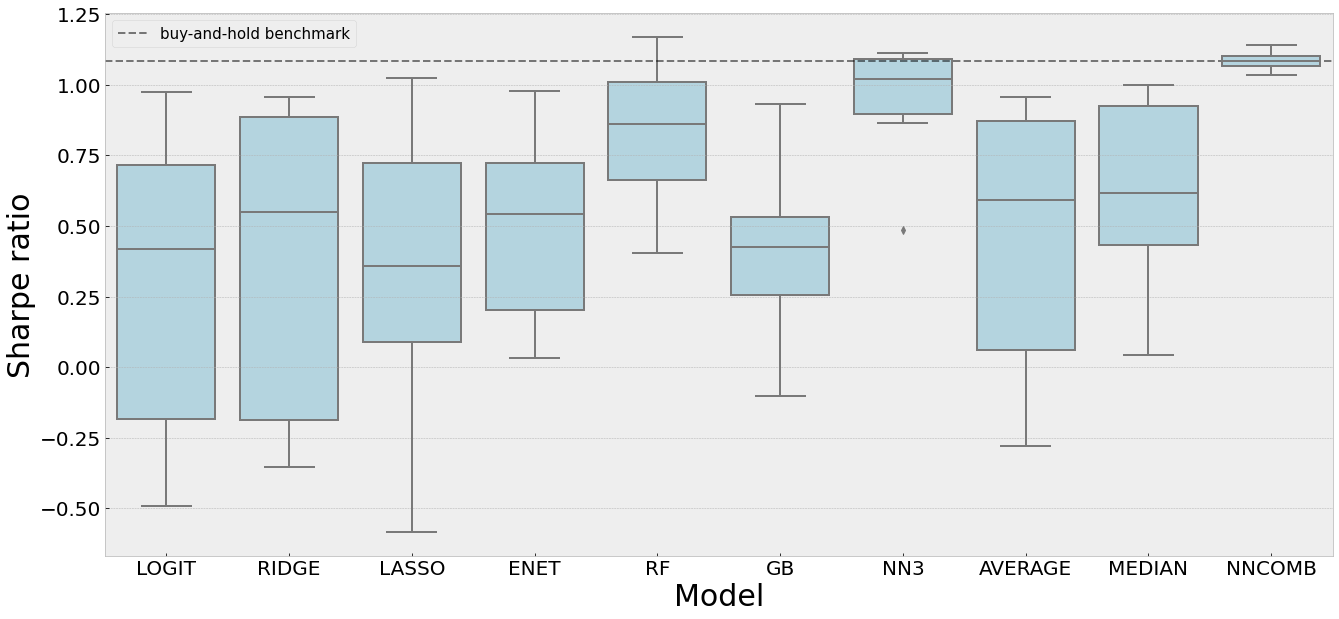

### 1.3) Out of sample Ann. Sharpe ratio distribution across feature selection methods (CCMP Index only)

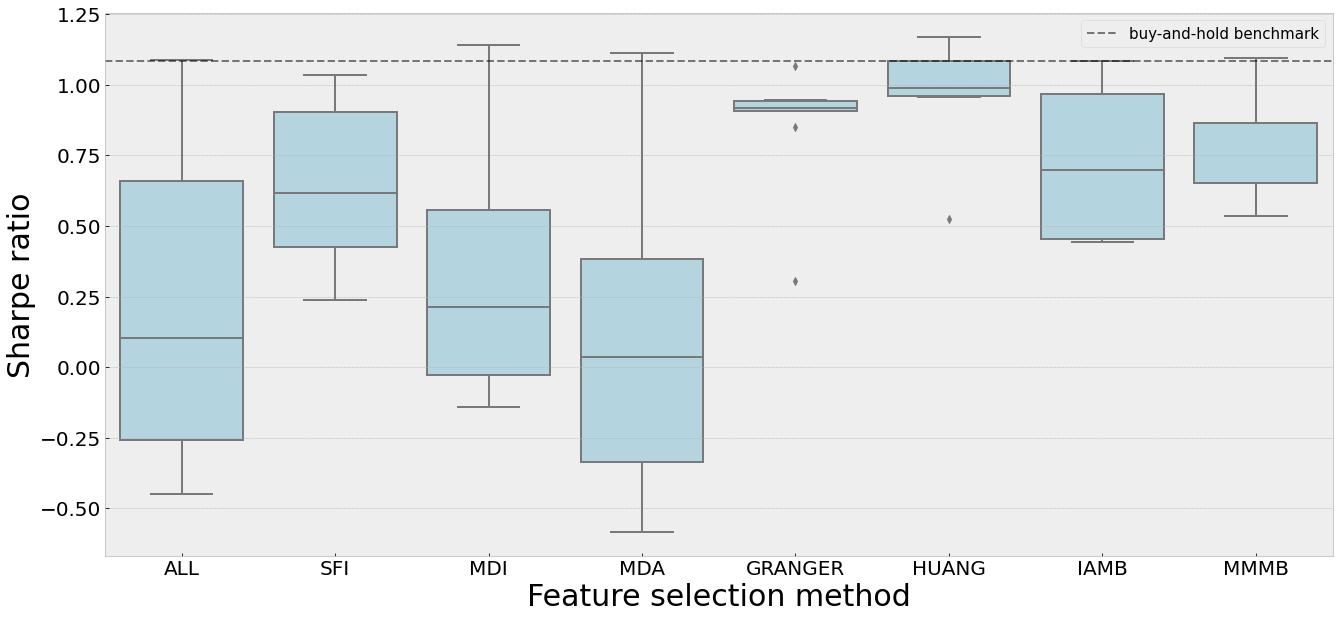

## 2) Calmar ratio - CCMP Index

### 2.1) Out of sample Ann. Calmar ratio median values (CCMP Index average benchmark 0.679)

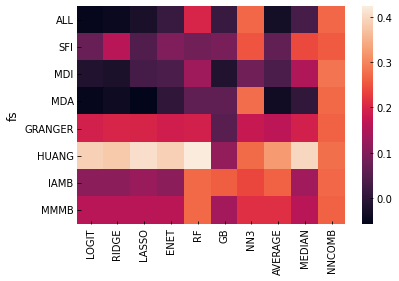

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &  -0.05 &  -0.04 &  -0.02 &  0.02 &  0.20 &  0.02 &  0.27 &    -0.03 &    0.03 &    0.27 \\
     SFI &   0.07 &   0.16 &   0.04 &  0.10 &  0.08 &  0.09 &  0.25 &     0.06 &    0.24 &    0.26 \\
     MDI &  -0.02 &  -0.02 &   0.03 &  0.04 &  0.13 & -0.02 &  0.08 &     0.04 &    0.15 &    0.28 \\
     MDA &  -0.05 &  -0.04 &  -0.06 &  0.00 &  0.06 &  0.06 &  0.28 &    -0.04 &    0.01 &    0.27 \\
 GRANGER &   0.19 &   0.20 &   0.20 &  0.19 &  0.19 &  0.05 &  0.18 &     0.17 &    0.19 &    0.27 \\
   HUANG &   0.39 &   0.38 &   0.41 &  0.39 &  0.42 &  0.12 &  0.28 &     0.33 &    0.40 &    0.28 \\
    IAMB &   0.11 &   0.11 &   0.13 &  0.11 &  0.27 &  0.26 &  0.24 &     0.27 &    0.14 &    0.27 \\
    MMMB &   0.16 &   0.16 &   0.16 &  0.16 &  0.27 &  0.14 &  0.22 &     0.22 &    0.16 &    0.27 \\
\bottomrule
\end{tabular}



### 2.2) Out of sample Ann. Calmar ratio distribution across forecasting models (CCMP Index only)

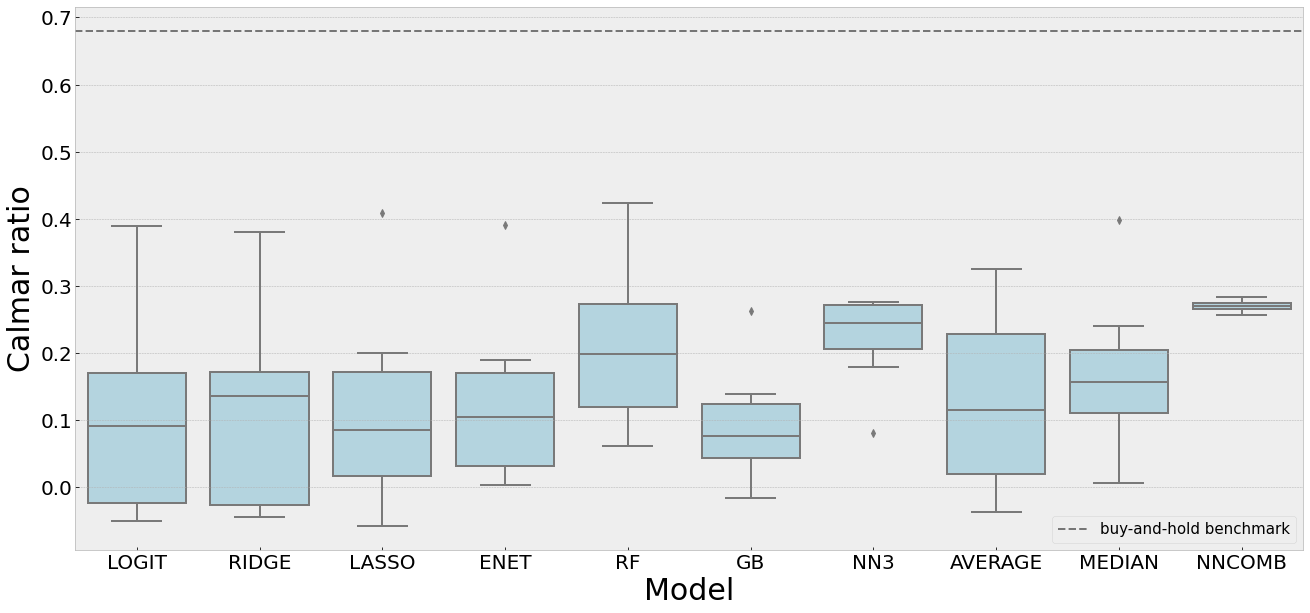

### 2.3) Out of sample Ann. Calmar ratio distribution across feature selection methods (CCMP Index only)

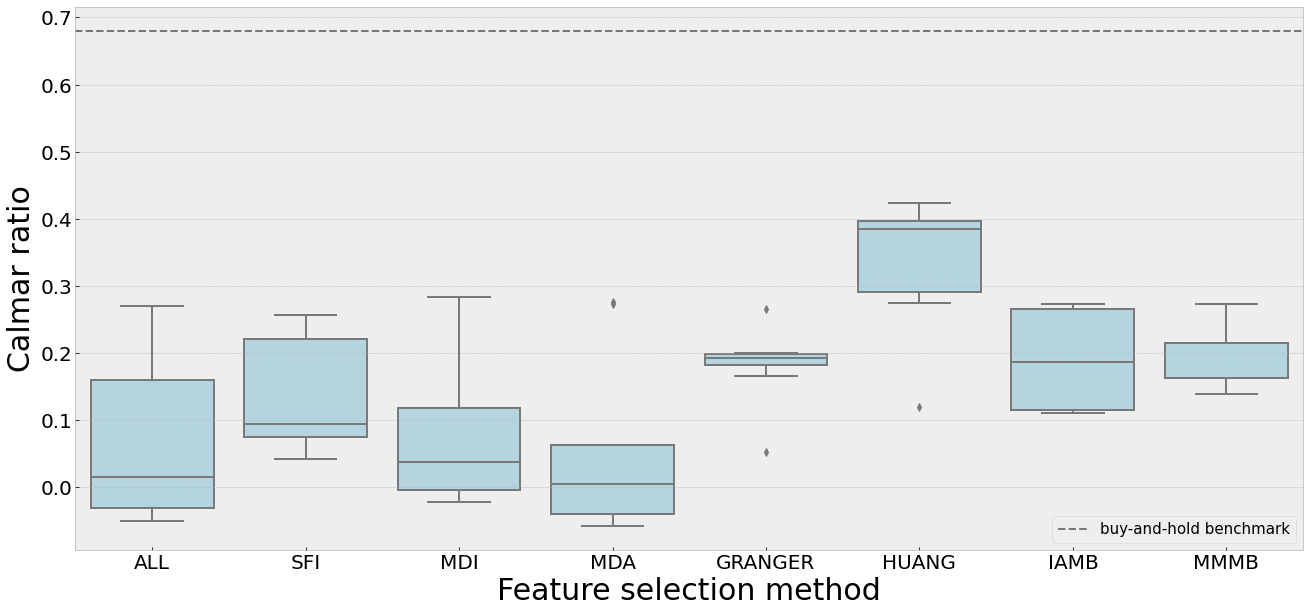

## 1) Sharpe ratio - RTY Index

### 1.1) Out of sample Ann. Sharpe ratio median values (RTY Index average benchmark 0.673)

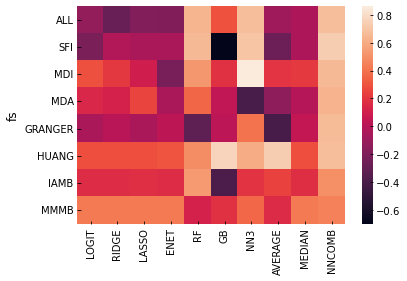

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &  -0.12 &  -0.28 &  -0.19 & -0.19 &  0.64 &  0.30 &  0.67 &    -0.08 &   -0.03 &    0.67 \\
     SFI &  -0.21 &  -0.02 &  -0.04 & -0.04 &  0.66 & -0.70 &  0.70 &    -0.27 &   -0.03 &    0.74 \\
     MDI &   0.29 &   0.21 &   0.10 & -0.22 &  0.53 &  0.19 &  0.86 &     0.20 &    0.22 &    0.66 \\
     MDA &   0.14 &   0.12 &   0.25 & -0.05 &  0.36 &  0.04 & -0.40 &    -0.14 &   -0.01 &    0.63 \\
 GRANGER &  -0.04 &   0.01 &  -0.04 &  0.03 & -0.32 &  0.02 &  0.40 &    -0.40 &    0.04 &    0.66 \\
   HUANG &   0.29 &   0.29 &   0.29 &  0.30 &  0.49 &  0.77 &  0.61 &     0.74 &    0.29 &    0.68 \\
    IAMB &   0.17 &   0.17 &   0.18 &  0.17 &  0.54 & -0.38 &  0.20 &     0.25 &    0.17 &    0.50 \\
    MMMB &   0.42 &   0.42 &   0.42 &  0.42 &  0.12 &  0.19 &  0.37 &     0.16 &    0.42 &    0.45 \\
\bottomrule
\end{tabular}



### 1.2) Out of sample Ann. Sharpe ratio distribution across forecasting models (RTY Index only)

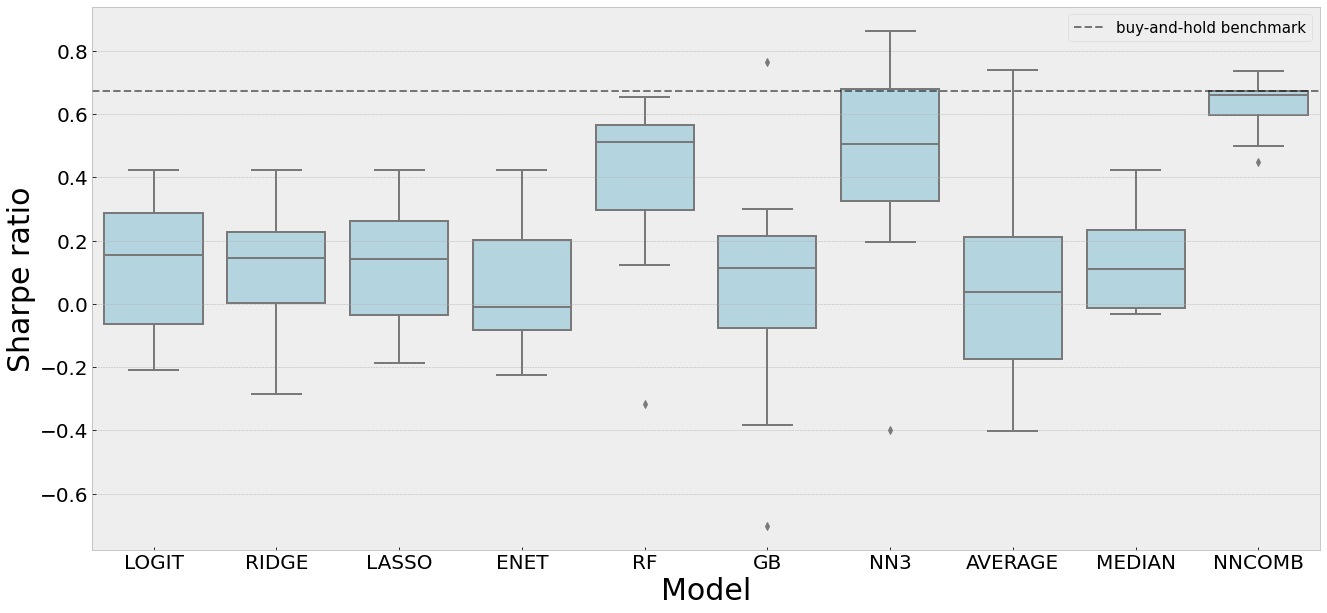

### 1.3) Out of sample Ann. Sharpe ratio distribution across feature selection methods (RTY Index only)

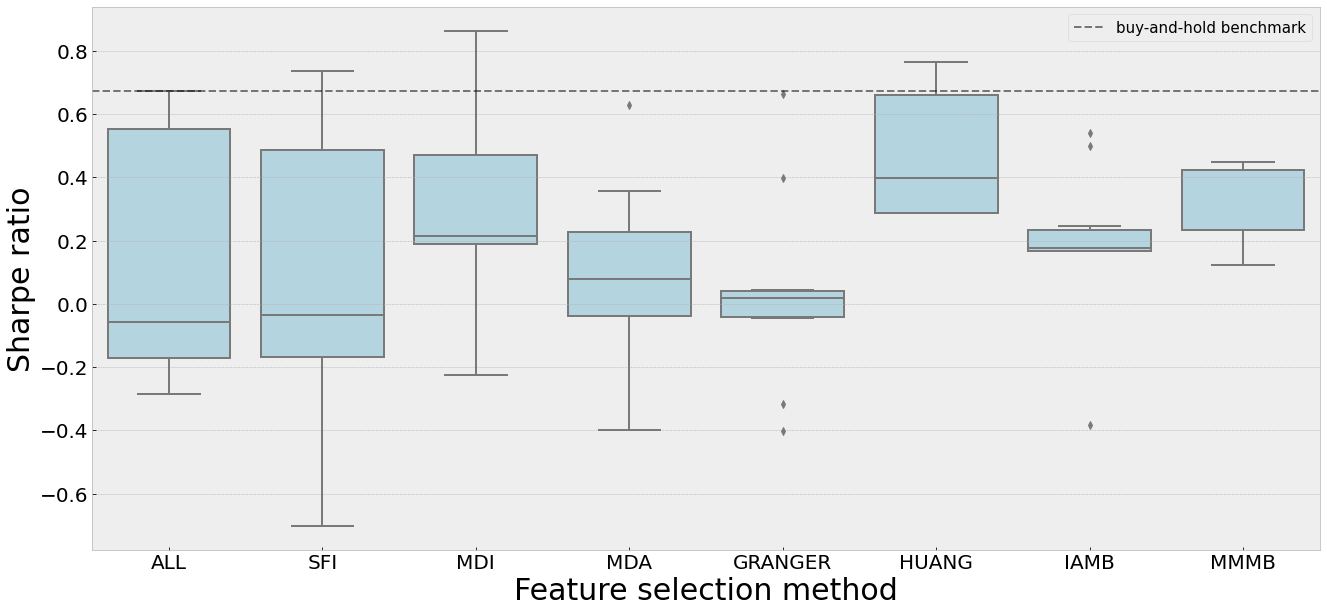

## 2) Calmar ratio - RTY Index

### 2.1) Out of sample Ann. Calmar ratio median values (RTY Index average benchmark 0.338)

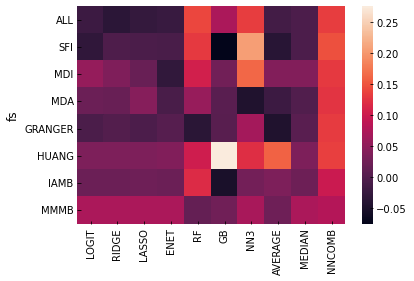

\begin{tabular}{lrrrrrrrrrr}
\toprule
      fs &  LOGIT &  RIDGE &  LASSO &  ENET &    RF &    GB &   NN3 &  AVERAGE &  MEDIAN &  NNCOMB \\
\midrule
     ALL &  -0.02 &  -0.03 &  -0.03 & -0.02 &  0.14 &  0.07 &  0.13 &    -0.01 &   -0.00 &    0.13 \\
     SFI &  -0.03 &  -0.00 &  -0.01 & -0.01 &  0.13 & -0.08 &  0.21 &    -0.04 &   -0.00 &    0.15 \\
     MDI &   0.06 &   0.04 &   0.02 & -0.03 &  0.11 &  0.03 &  0.16 &     0.04 &    0.04 &    0.13 \\
     MDA &   0.02 &   0.02 &   0.04 & -0.01 &  0.06 &  0.01 & -0.04 &    -0.02 &   -0.00 &    0.13 \\
 GRANGER &  -0.01 &   0.00 &  -0.00 &  0.00 & -0.04 &  0.00 &  0.07 &    -0.05 &    0.01 &    0.13 \\
   HUANG &   0.04 &   0.04 &   0.04 &  0.04 &  0.10 &  0.28 &  0.12 &     0.16 &    0.04 &    0.14 \\
    IAMB &   0.02 &   0.02 &   0.02 &  0.02 &  0.12 & -0.05 &  0.03 &     0.04 &    0.02 &    0.10 \\
    MMMB &   0.07 &   0.07 &   0.07 &  0.07 &  0.02 &  0.03 &  0.07 &     0.02 &    0.07 &    0.08 \\
\bottomrule
\end{tabular}



### 2.2) Out of sample Ann. Calmar ratio distribution across forecasting models (RTY Index only)

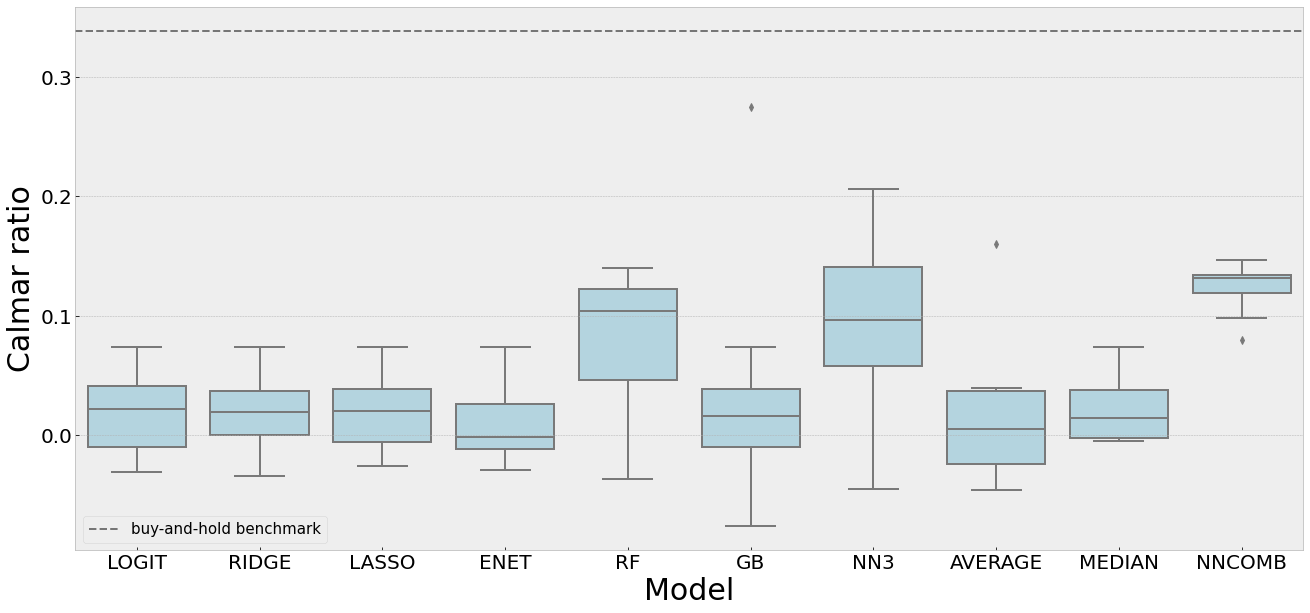

### 2.3) Out of sample Ann. Calmar ratio distribution across feature selection methods (RTY Index only)

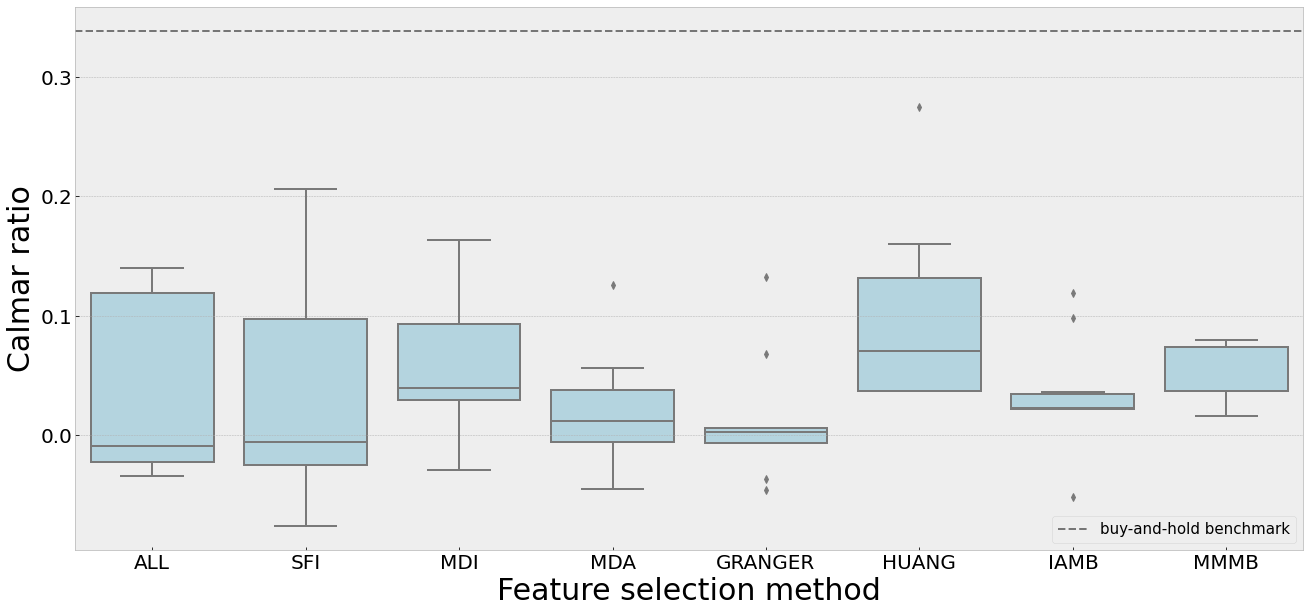

In [16]:
for ts in tickers_to_analyze:
    # subset returns
    tmp_ret_all_df = ret_all_df.loc[ret_all_df['ticker'] == ts].dropna()
    
    display(Markdown("## 1) Sharpe ratio - " + ts))
    average_sr = sr_benchmark.loc[sr_benchmark['ticker'] == ts]['Sharpe ratio'].iloc[0]
    sr_rank_df, sr_tb_df, sr_agg_df = sharpe_ratio_tb(returns_df=tmp_ret_all_df,
                                                      level_to_subset='fs',
                                                      rf=.0)
    sr_df = sr_rank_df.reset_index()
    sr_df_raw = sr_df.loc[sr_df["fs"]=="raw"].reset_index(drop=True)
    sr_df = sr_df.loc[sr_df["fs"]!="raw"].reset_index(drop=True)
    sr_df_spx = sr_df.loc[sr_df["ticker"]==ts].reset_index(drop=True)

    # Sanity Check
    assert oos_melt_auc_df.loc[oos_melt_auc_df['ticker'] == ts].shape[0] == sr_df.shape[0]

    simple_sr_df = sr_df.pivot_table(index=['fs'], columns=['model'], values=['Sharpe ratio'], aggfunc='median')
    simple_cols = [c[1] for c in simple_sr_df.columns]
    simple_sr_df.columns = simple_cols
    simple_sr_df = simple_sr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

    display(Markdown("### 1.1) Out of sample Ann. Sharpe ratio median values (" + ts + " average benchmark {:.3f})".format(average_sr)))
    display(HTML(simple_sr_df.to_html()))
    sns.heatmap(simple_sr_df);
    plt.show()
    print((simple_sr_df.apply(lambda x: np.round(x,2))).reset_index().to_latex(index=False))

    display(Markdown("### 1.2) Out of sample Ann. Sharpe ratio distribution across forecasting models (" + ts + " only)"))
    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="model", y='Sharpe ratio', data=sr_df, ax=ax, order=models2, color='lightblue');
    ax.set_ylabel("Sharpe ratio", fontsize=30);
    ax.set_xlabel("Model", fontsize=30);
    ax.axhline(y=average_sr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_sr_models_distr_" + ts.split(" ")[0].lower() + ".png")

    display(Markdown("### 1.3) Out of sample Ann. Sharpe ratio distribution across feature selection methods (" + ts + " only)"))
    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="fs", y='Sharpe ratio',data=sr_df, ax=ax, order=fs_methods2, color='lightblue');
    ax.set_ylabel("Sharpe ratio", fontsize=30);
    ax.set_xlabel("Feature selection method", fontsize=30);
    ax.axhline(y=average_sr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_sr_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")
    
    display(Markdown("## 2) Calmar ratio - " + ts))
    average_cr = cr_benchmark.loc[cr_benchmark['ticker'] == ts]['Calmar ratio'].iloc[0]
    cr_rank_df, cr_tb_df, cr_agg_df = calmar_ratio_tb(returns_df=tmp_ret_all_df,
                                                      level_to_subset='fs')
    cr_df = cr_rank_df.reset_index()
    cr_df_raw = cr_df.loc[cr_df["fs"]=="raw"].reset_index(drop=True)
    cr_df = cr_df.loc[cr_df["fs"]!="raw"].reset_index(drop=True)
    cr_df_spx = cr_df.loc[cr_df["ticker"]==ts].reset_index(drop=True)

    # Sanity Check
    assert oos_melt_auc_df.loc[oos_melt_auc_df['ticker'] == ts].shape[0] == cr_df.shape[0]

    simple_cr_df = cr_df.pivot_table(index=['fs'], columns=['model'], values=['Calmar ratio'], aggfunc='median')
    simple_cols = [c[1] for c in simple_cr_df.columns]
    simple_cr_df.columns = simple_cols
    simple_cr_df = simple_cr_df.loc[fs_methods2][models2].apply(lambda x: np.round(x,3))

    display(Markdown("### 2.1) Out of sample Ann. Calmar ratio median values (" + ts + " average benchmark {:.3f})".format(average_cr)))
    display(HTML(simple_cr_df.to_html()))
    sns.heatmap(simple_cr_df);
    plt.show()
    print((simple_cr_df.apply(lambda x: np.round(x,2))).reset_index().to_latex(index=False))

    display(Markdown("### 2.2) Out of sample Ann. Calmar ratio distribution across forecasting models (" + ts + " only)"))
    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="model", y='Calmar ratio', data=cr_df, ax=ax, order=models2, color='lightblue');
    ax.set_ylabel("Calmar ratio", fontsize=30);
    ax.set_xlabel("Model", fontsize=30);
    ax.axhline(y=average_cr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_cr_models_distr_" + ts.split(" ")[0].lower() + ".png")

    display(Markdown("### 2.3) Out of sample Ann. Calmar ratio distribution across feature selection methods (" + ts + " only)"))
    fig, ax = plt.subplots(figsize=(22,10))
    sns.boxplot(x="fs", y='Calmar ratio',data=cr_df, ax=ax, order=fs_methods2, color='lightblue');
    ax.set_ylabel("Calmar ratio", fontsize=30);
    ax.set_xlabel("Feature selection method", fontsize=30);
    ax.axhline(y=average_cr, color='k', linestyle='--', alpha=0.5, label="buy-and-hold benchmark");
    ax.tick_params(axis="x", labelsize=20);
    ax.tick_params(axis="y", labelsize=20);
    ax.legend(loc="best",fontsize=15);
    plt.show()
    fig.savefig("img/oos_cr_fs_methods_distr_" + ts.split(" ")[0].lower() + ".png")

## 3) Cummulative returns

## 1) Cummulative returns - SPX Index

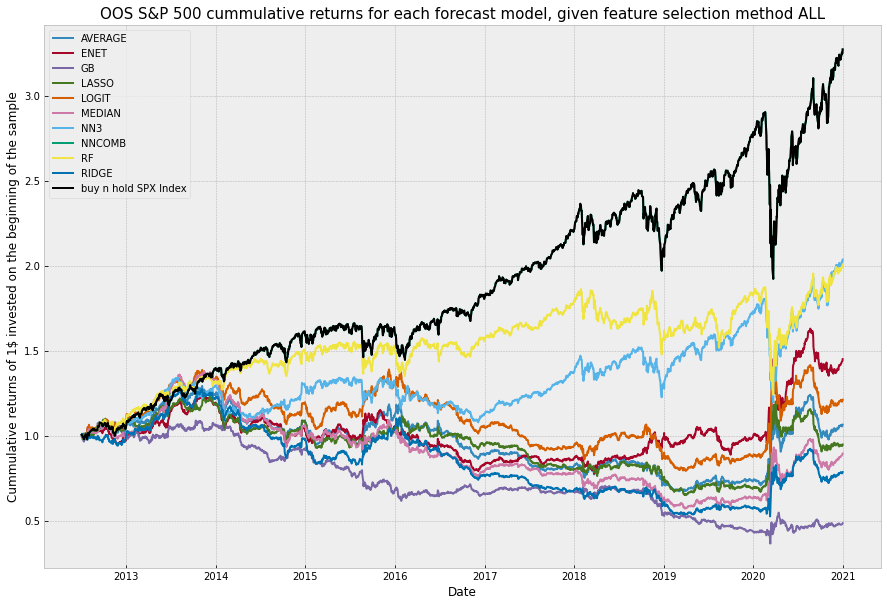

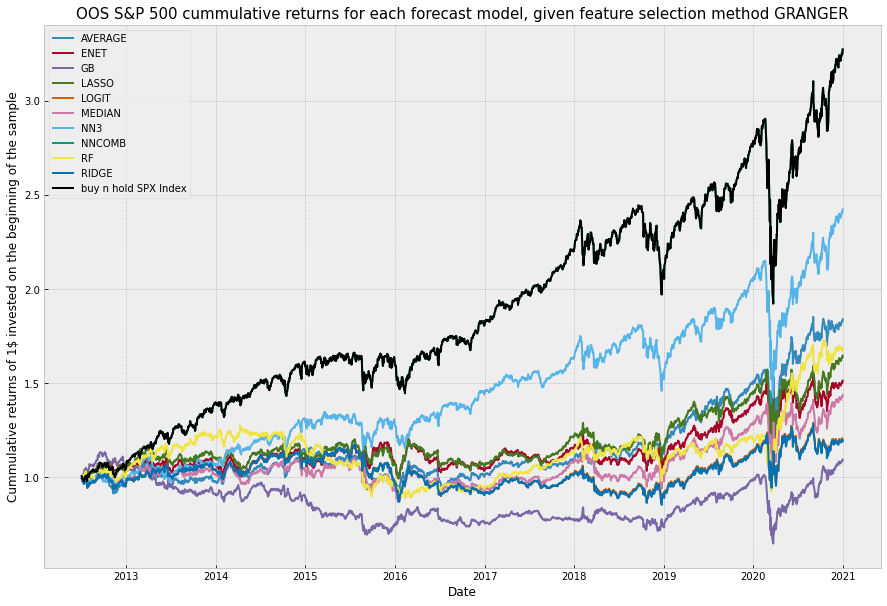

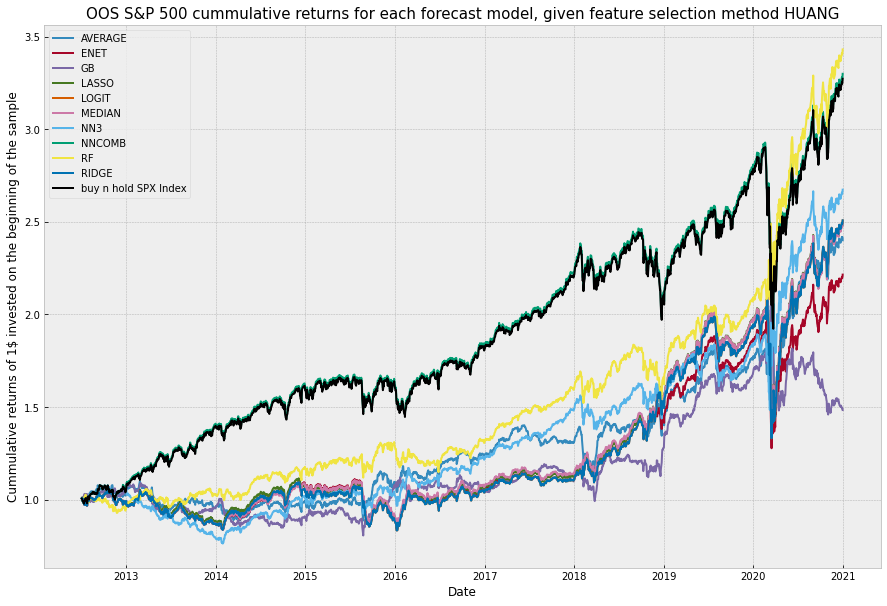

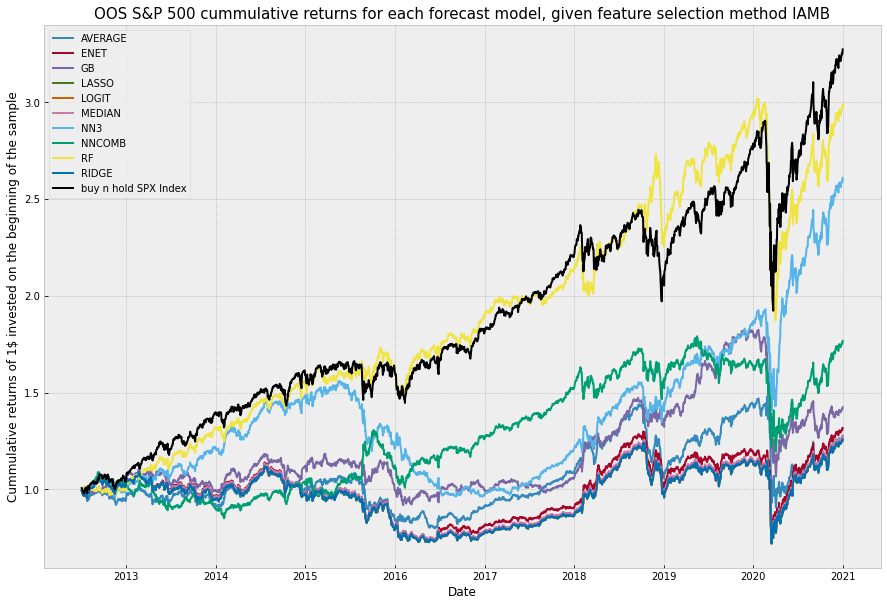

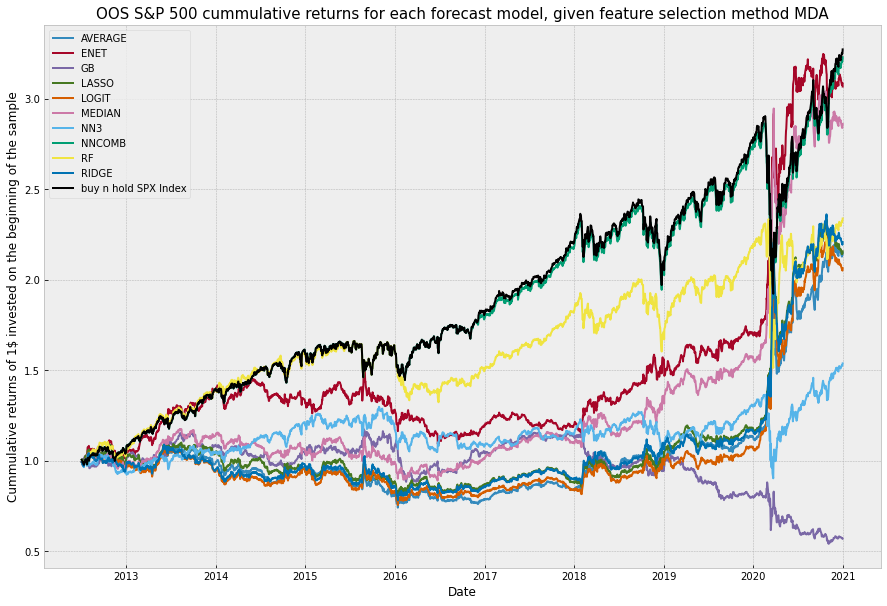

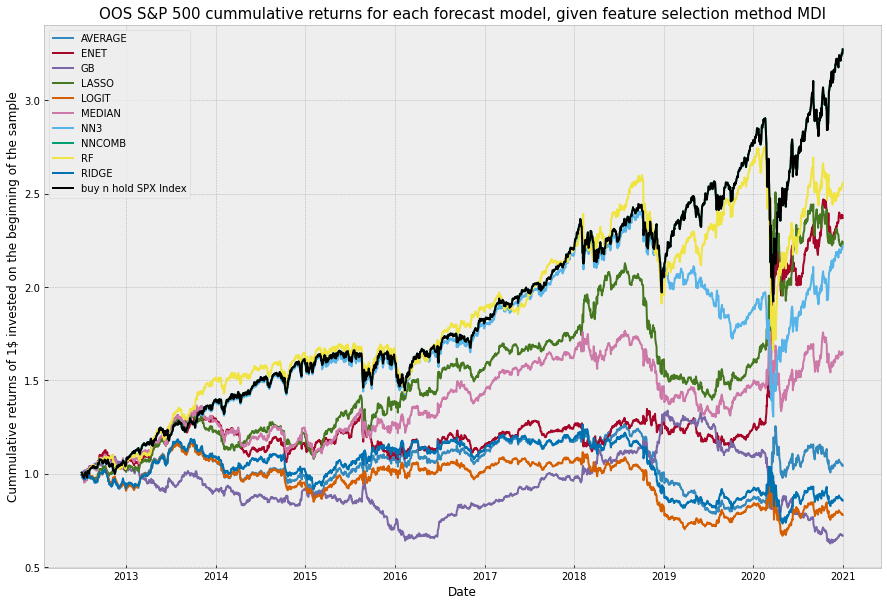

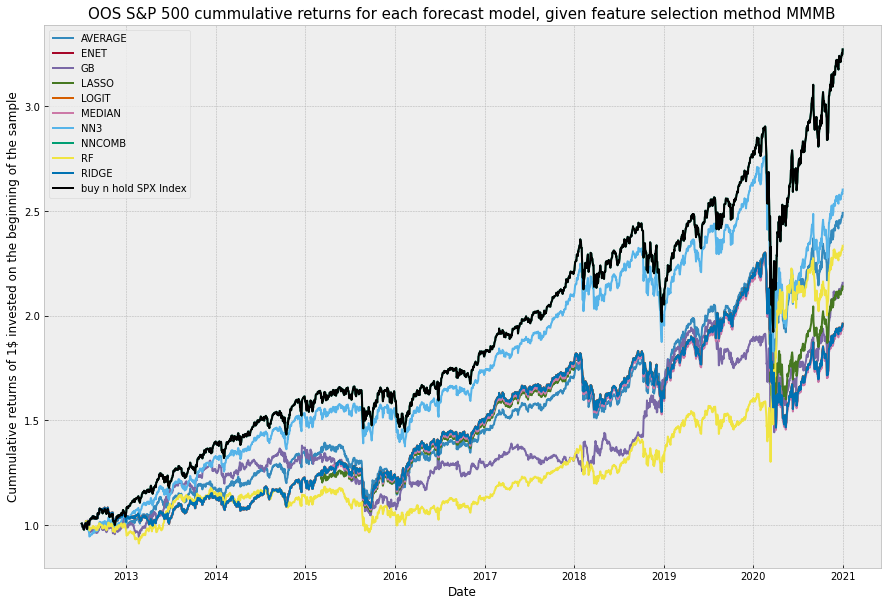

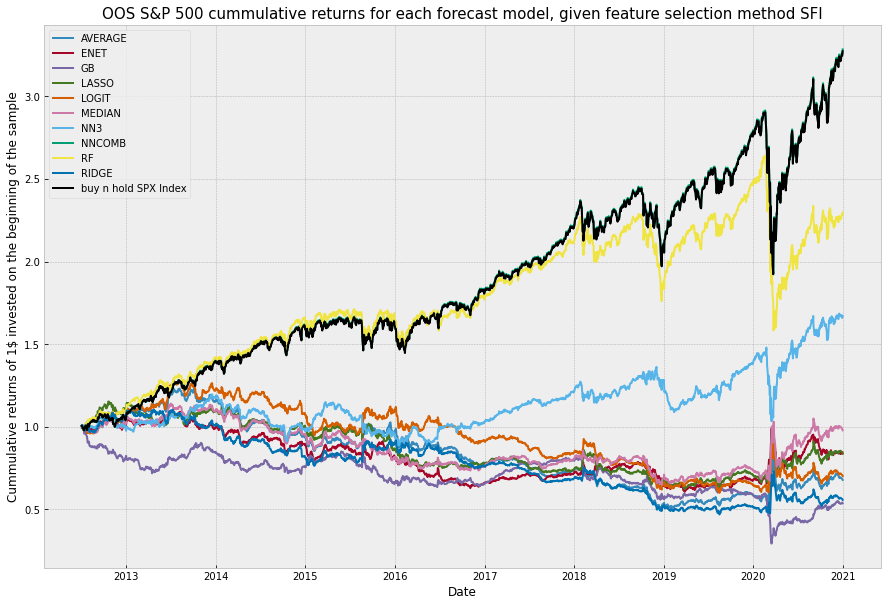

## 2) Cummulative returns - CCMP Index

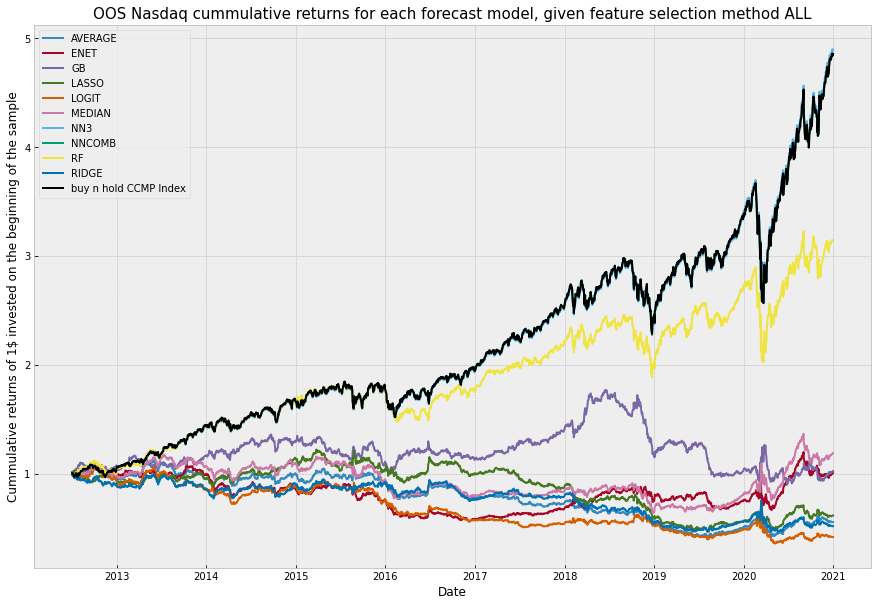

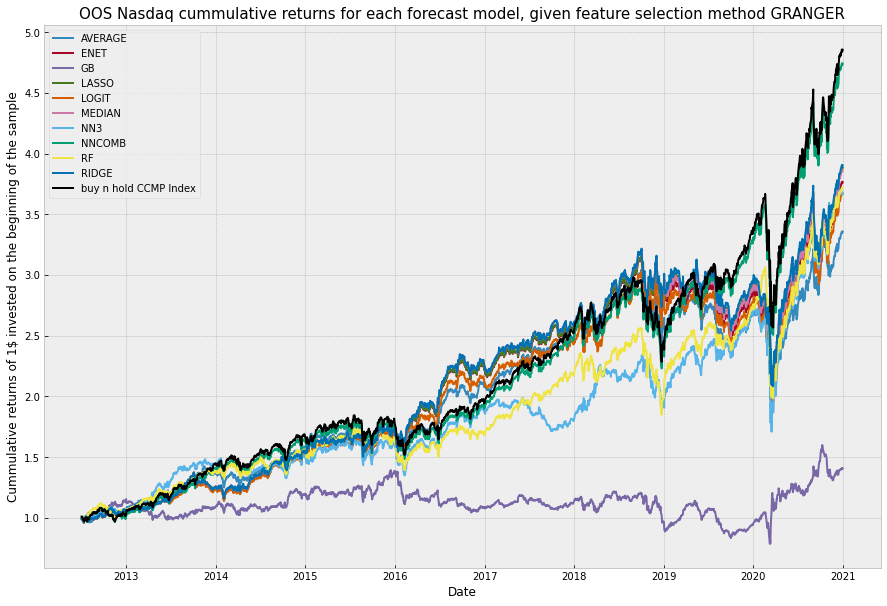

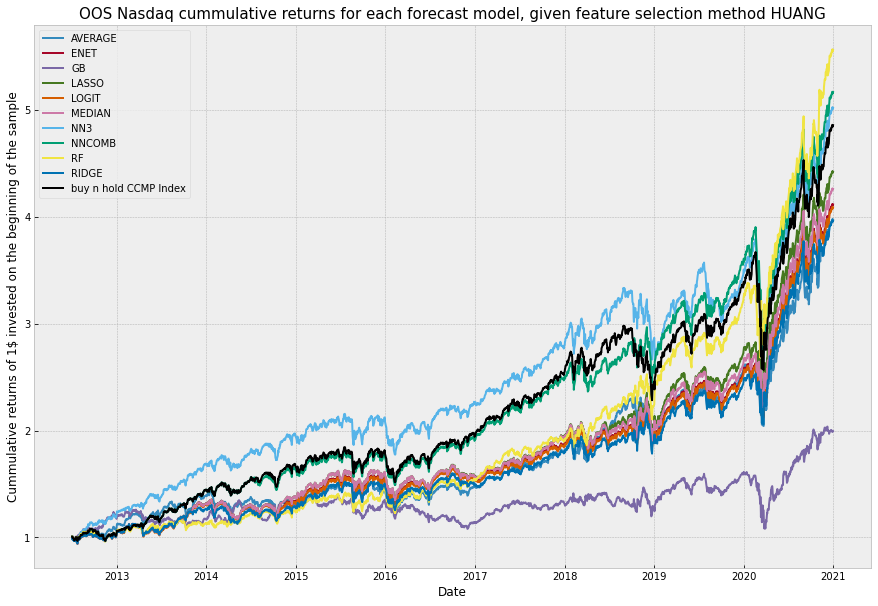

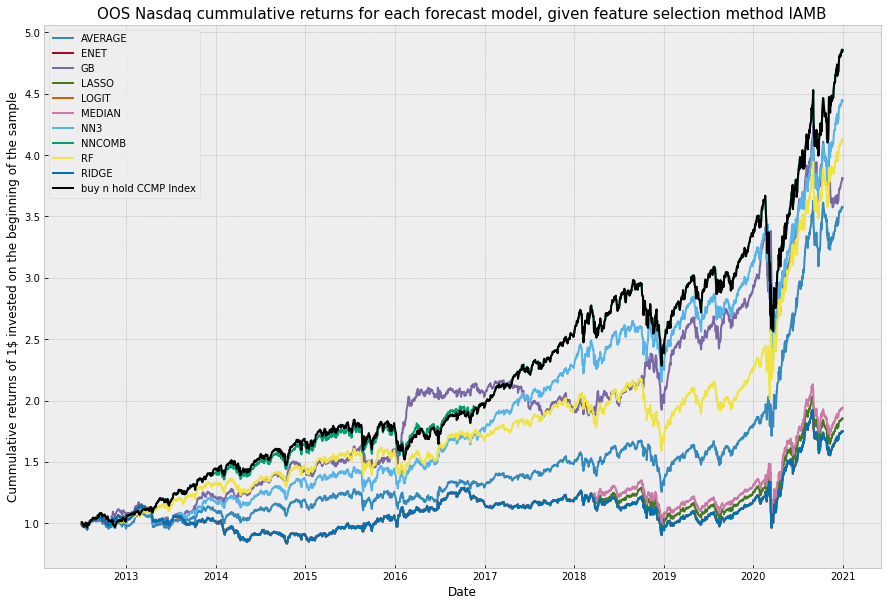

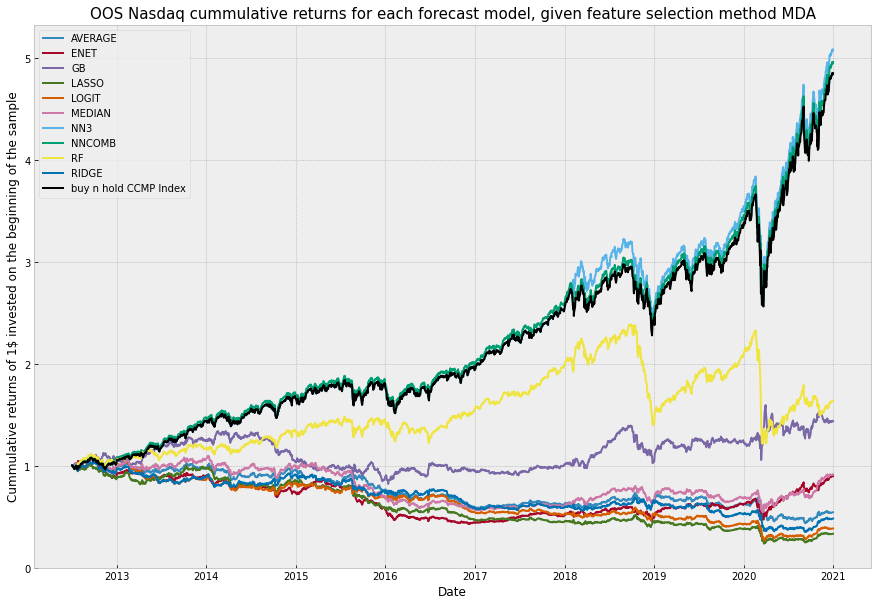

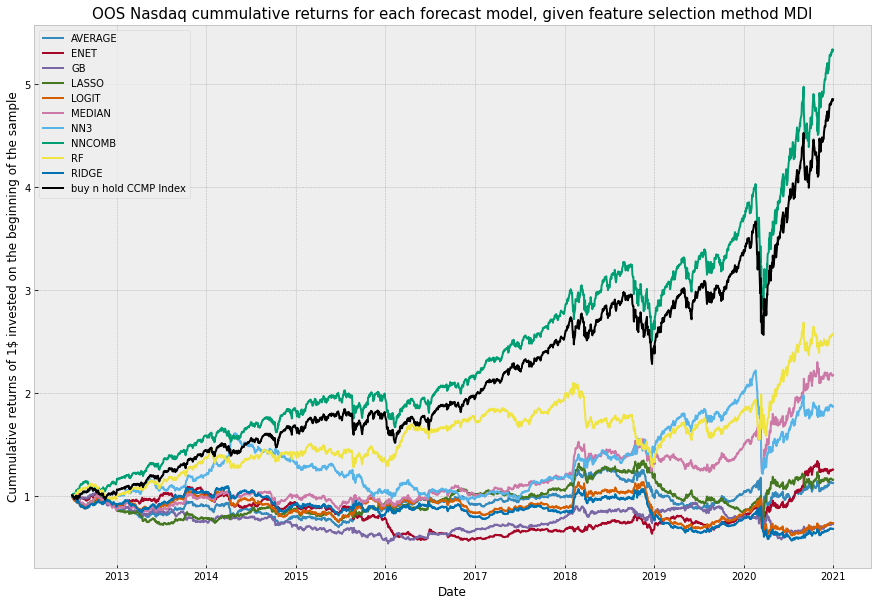

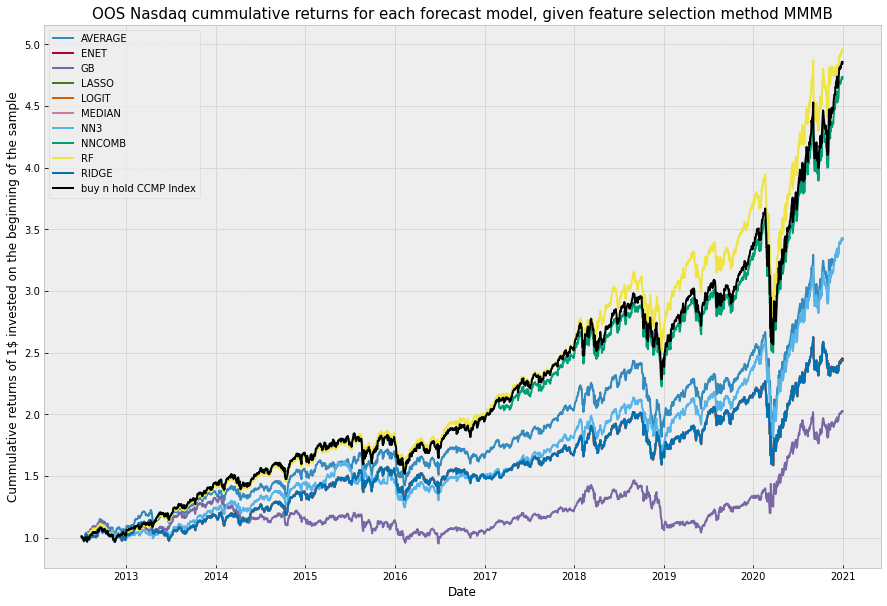

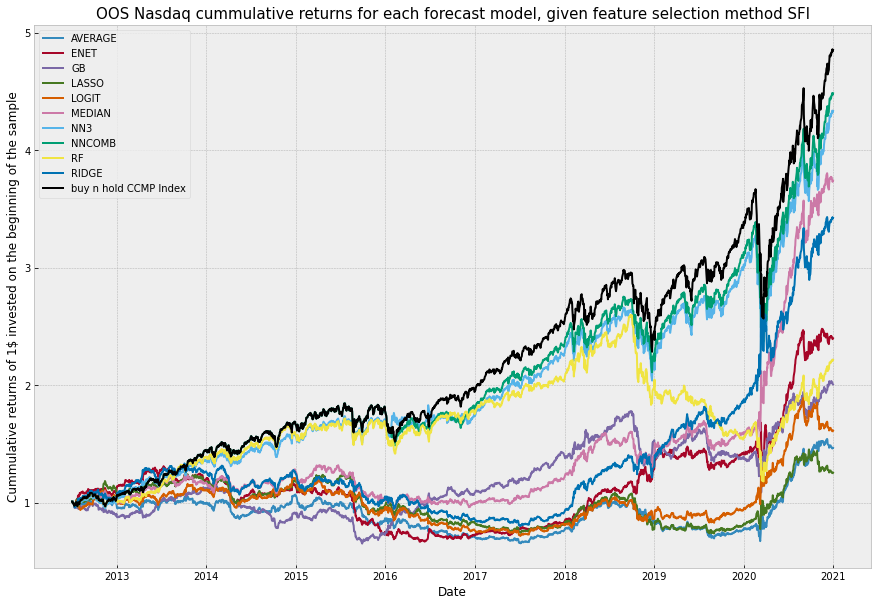

## 3) Cummulative returns - RTY Index

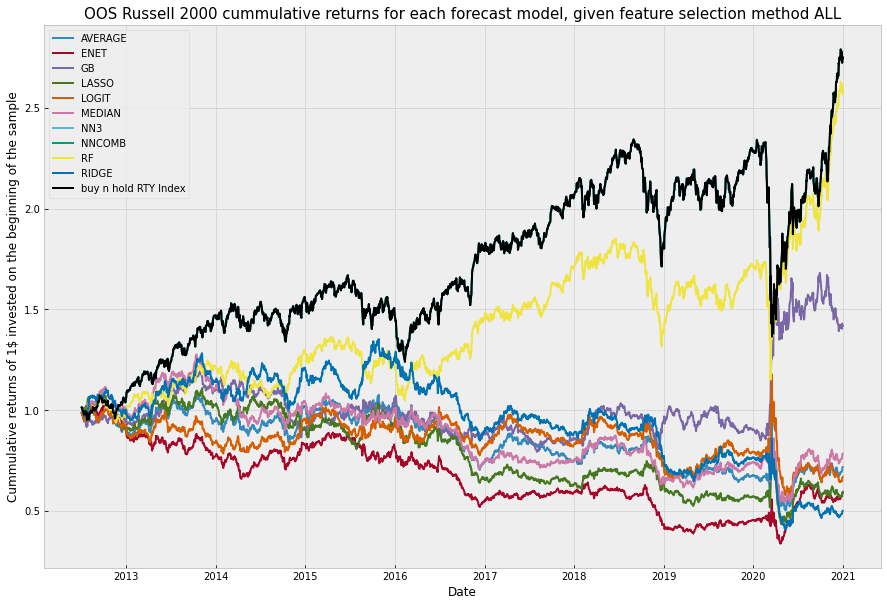

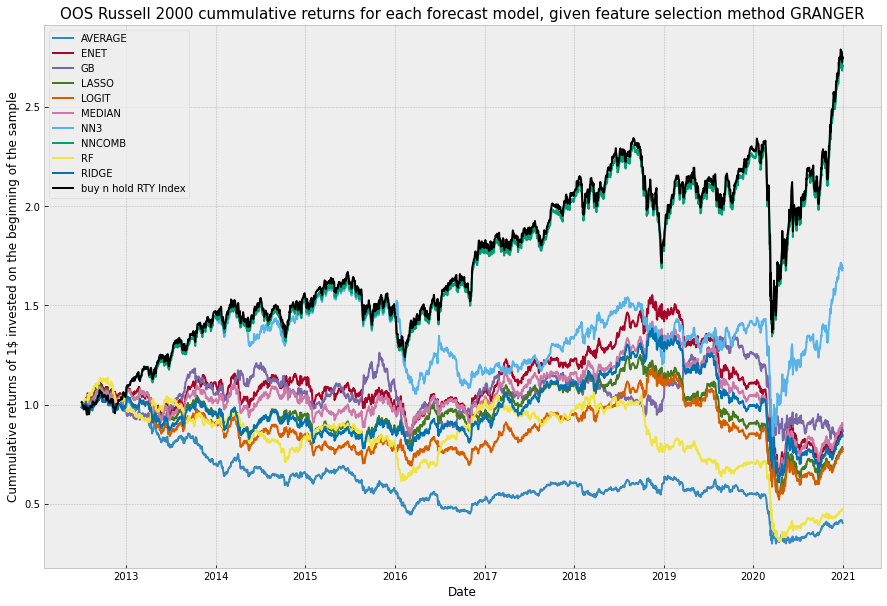

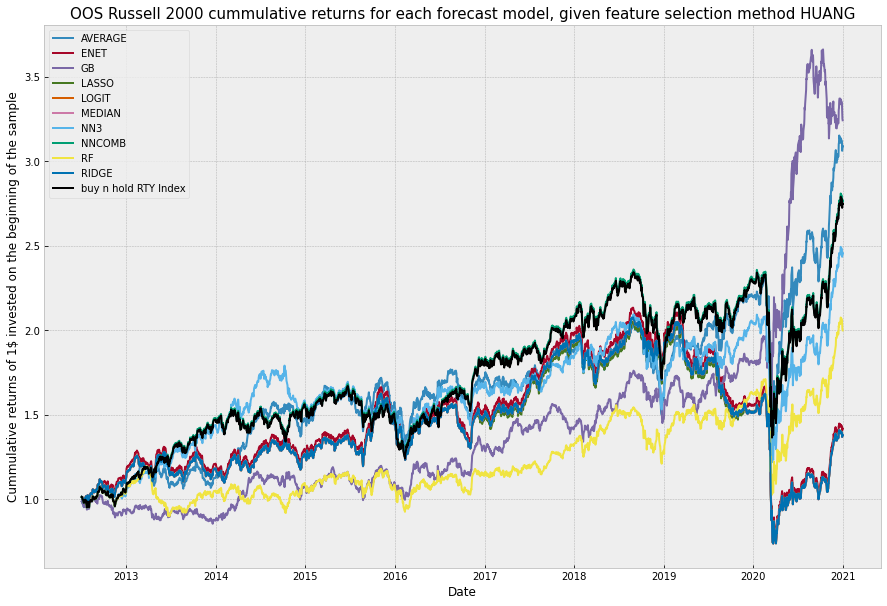

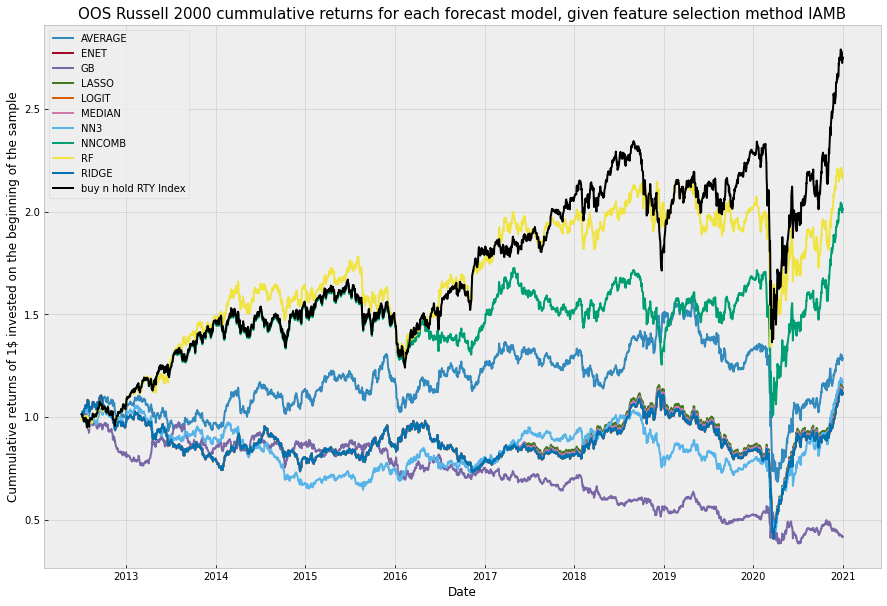

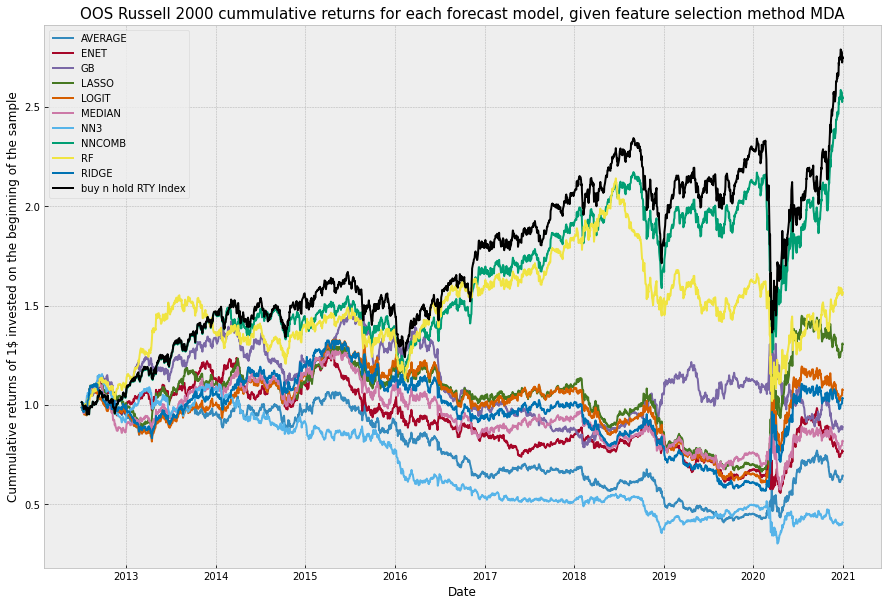

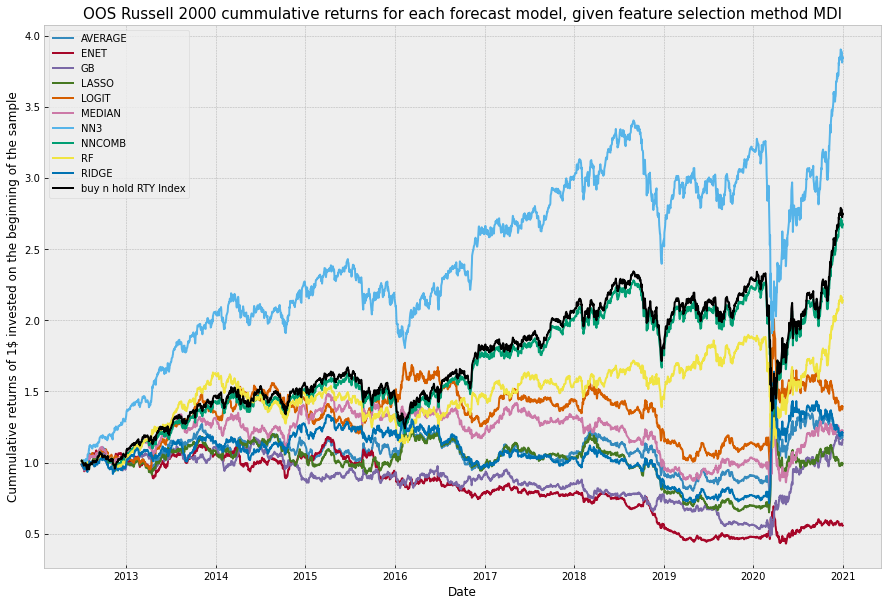

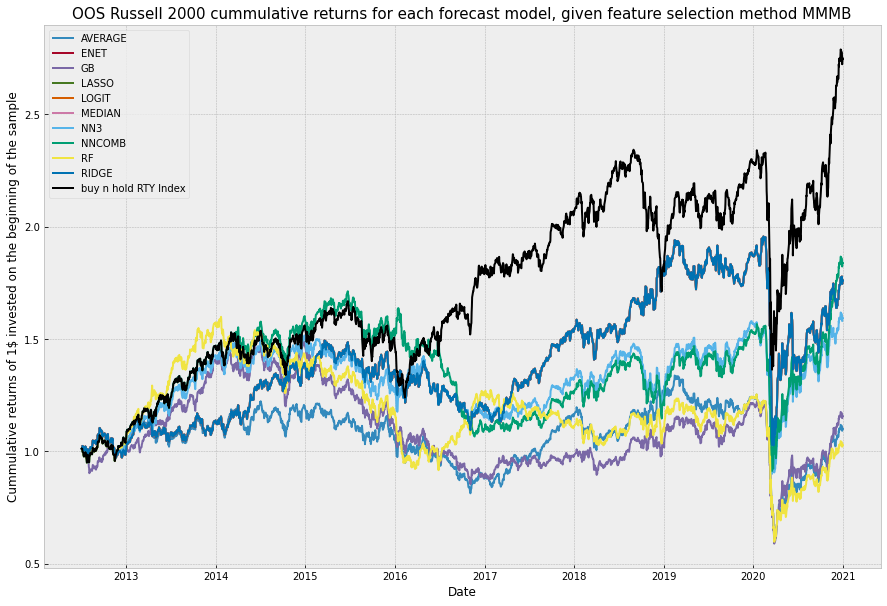

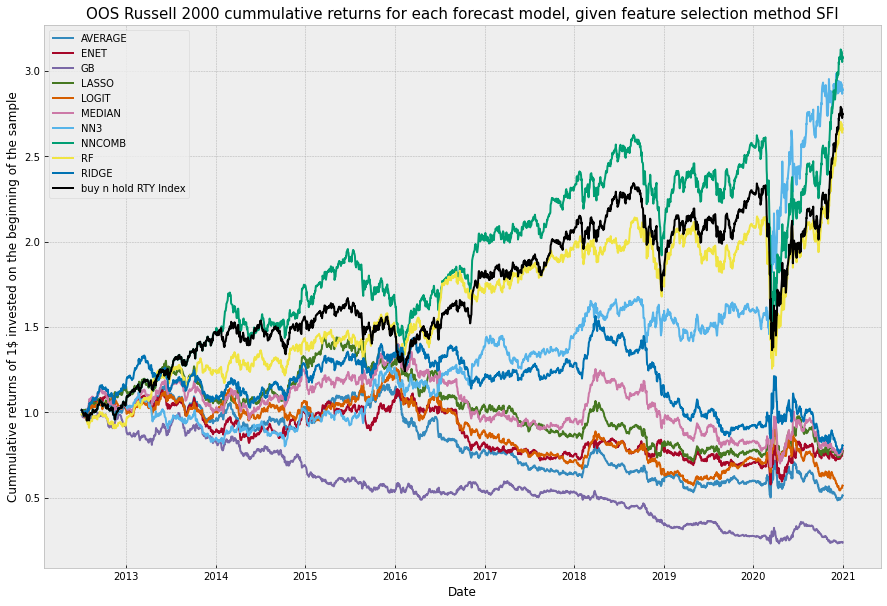

In [17]:
for idx, ticker in enumerate(tickers_to_analyze):
    display(Markdown("## " + str(idx+1) + ") Cummulative returns - " + ticker))
    
    summary_oos_pred_ret_df = oos_pred_ret_df.loc[oos_pred_ret_df['ticker']==ticker]
    summary_benchmark_df = benchmark_df.loc[benchmark_df['ticker']==ticker]

    for key1 in summary_oos_pred_ret_df['fs'].unique():
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(label='OOS ' + tickers_tags[ticker] + ' cummulative returns for each forecast model, given feature selection method ' + key1, fontsize=15)

        for key2 in summary_oos_pred_ret_df['model'].unique():
            loop_df = summary_oos_pred_ret_df.loc[(summary_oos_pred_ret_df['fs'] == key1)&
                                                  (summary_oos_pred_ret_df['model'] == key2)&
                                                  (summary_oos_pred_ret_df['ticker'] == ticker)]
            ax.plot(pd.to_datetime(loop_df['date']), (1+loop_df['value']/100).cumprod(), label=key2)

        bench = summary_benchmark_df.loc[(summary_benchmark_df['ticker']==ticker)&(summary_benchmark_df['date'] >= loop_df['date'].iloc[0])]
        ax.plot(pd.to_datetime(bench['date']), (1+bench['value']/100).cumprod(), label='buy n hold ' + ticker, color='black', linewidth=2)

        plt.xlabel("Date")
        plt.ylabel("Cummulative returns of 1$ invested on the beginning of the sample")
        plt.legend(loc='best', fontsize=10)   
        fig.savefig('img/' + ticker + '_' + key1 + '_fs_methods.png')
        plt.show()

## 4) Simulation comparison between the Sharpe ratio and the AUC

In [18]:
spx_df = benchmark_df.loc[benchmark_df['ticker']=='SPX Index']
oos_spx_df = spx_df.loc[spx_df['date']>=oos_start_date]
pivot_oos_spx_df = oos_spx_df.pivot_table(index=['date'], columns=['ticker'], values=['value'])
pivot_oos_spx_df.columns = pivot_oos_spx_df.columns.droplevel()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


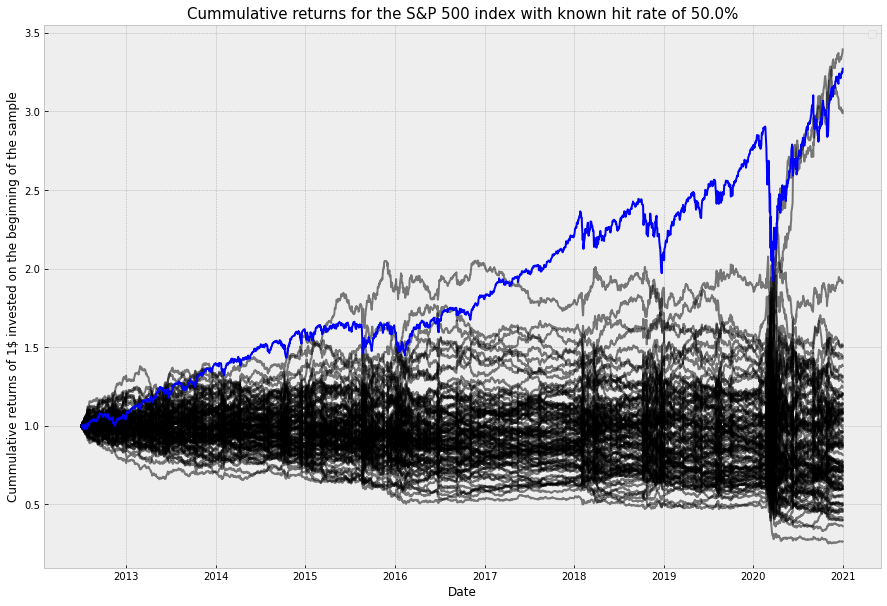

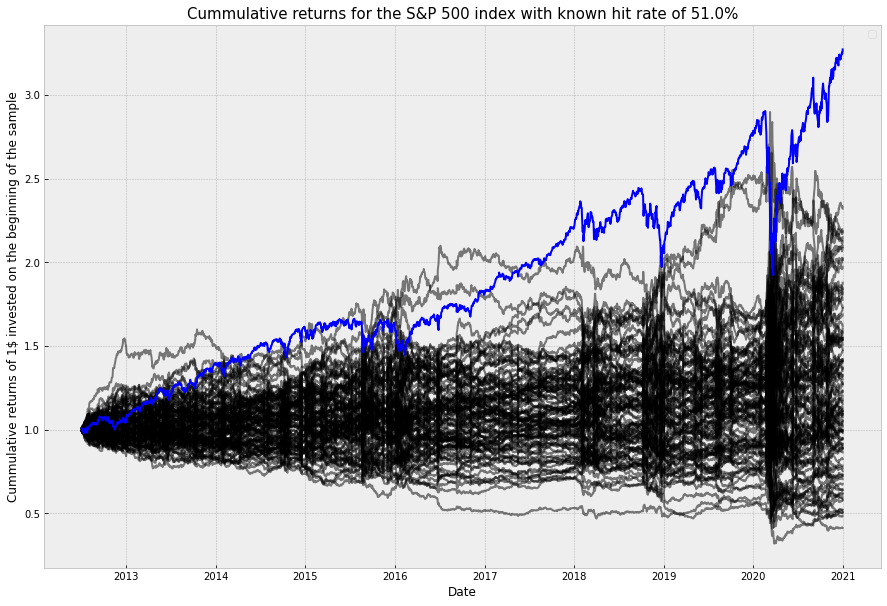

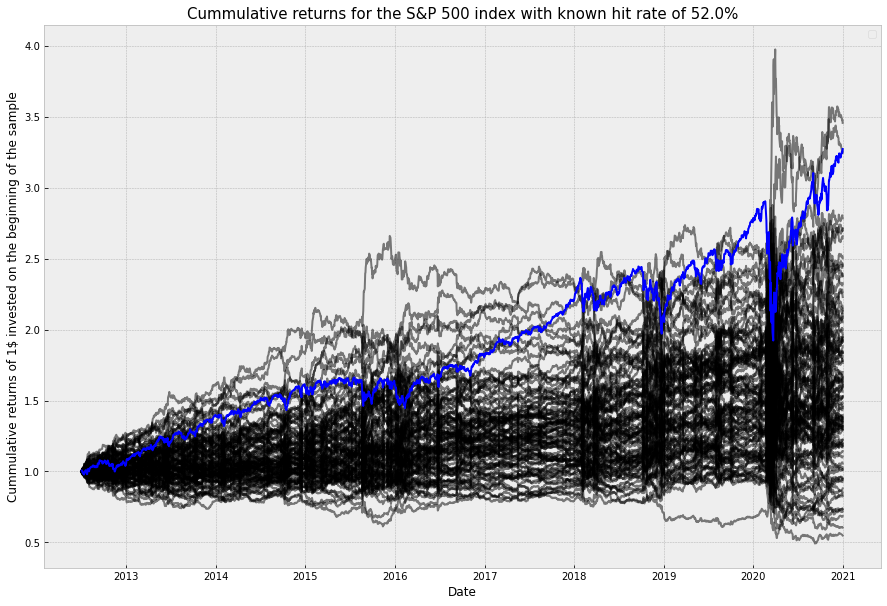

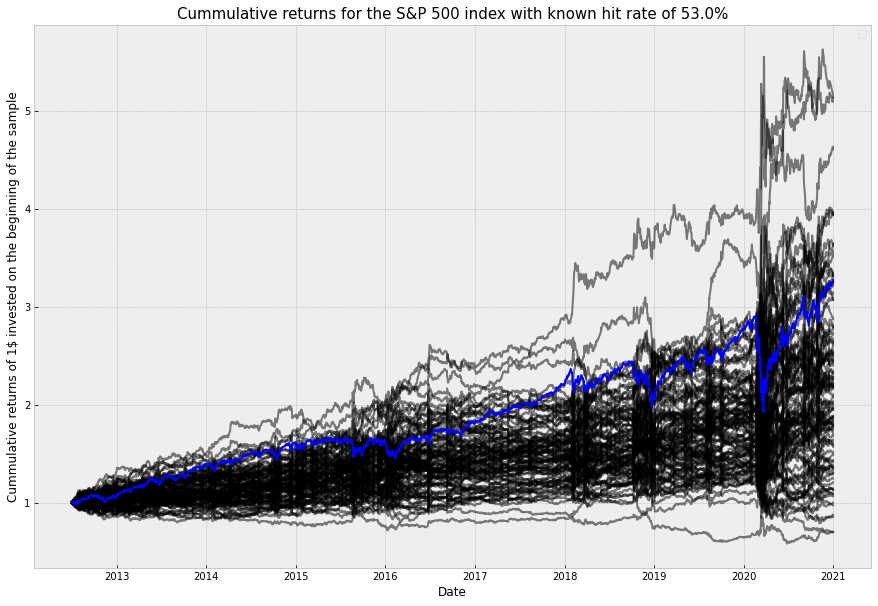

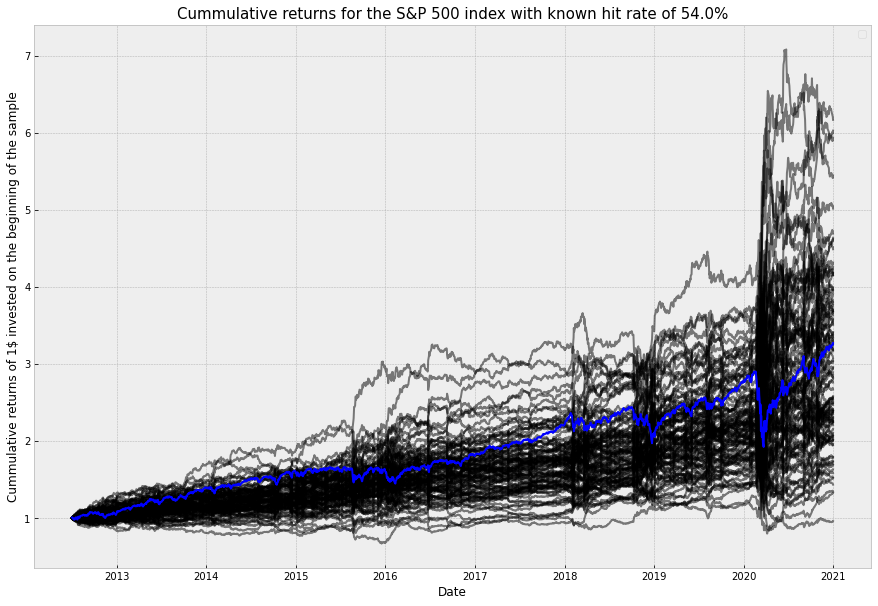

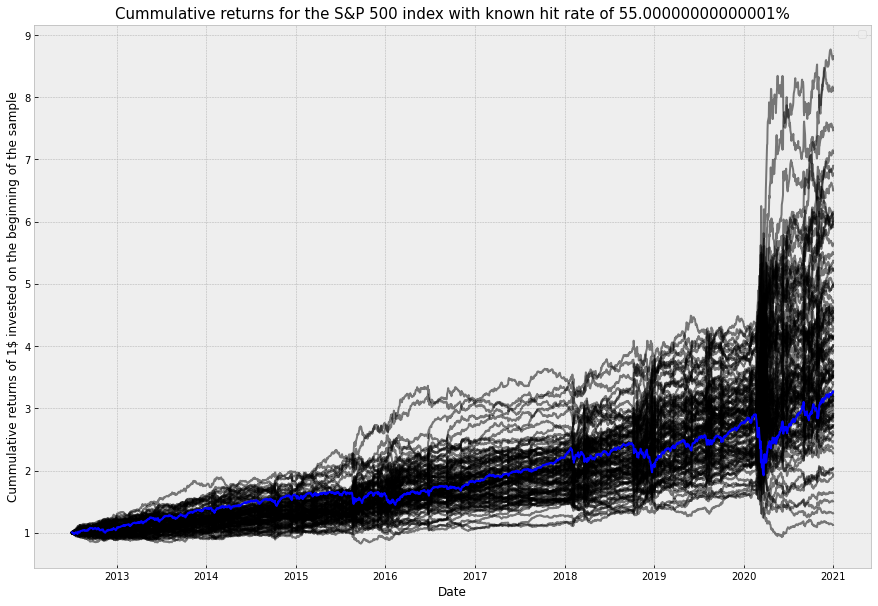

In [19]:
simu_num = 100
ps = [0.5, 0.51, 0.52, 0.53, 0.54, 0.55]

true_class_df = pivot_oos_spx_df.copy()
true_class_df.loc[true_class_df[true_class_df.columns[0]] > 0] = 1
true_class_df.loc[true_class_df[true_class_df.columns[0]] < 0] = -1

for p in ps:
    out_simu_list = []
    n = int(np.round(true_class_df.shape[0] * p))

    for i in range(0, simu_num+1):
        name = 'random' + str(i)
        sample_true_class_df = true_class_df.sample(n=n, replace=False)
        sample_true_class_df.rename(columns={sample_true_class_df.columns[0]: name}, inplace=True)
        simu_df = pd.concat([true_class_df, sample_true_class_df], axis=1)
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] > 0), name] = -1
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] < 0), name] = 1
        simu_df = simu_df[[name]]
        
        spx_simu_df = pd.DataFrame(simu_df.values * pivot_oos_spx_df.values,
                                  columns=['spx_random_pred' + str(i)])
        out_simu_list.append(spx_simu_df)
    out_simu_df = pd.concat(out_simu_list, axis=1)
    out_simu_df.index = pivot_oos_spx_df.index

    out_simu_df = pd.concat([out_simu_df, pivot_oos_spx_df], axis=1)
    out_simu_df = out_simu_df.reset_index()

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.set_title('Cummulative returns for the S&P 500 index with known hit rate of ' + str(p*100) + '%',
                fontsize=15)

    for key in out_simu_df.columns:
        if key == 'date':
            continue

        if key == 'SPX Index':
            ax.plot(pd.to_datetime(out_simu_df['date']),
                    (1 + out_simu_df[key]/100).cumprod(),
                    color='blue')
        else:
             ax.plot(pd.to_datetime(out_simu_df['date']),
                    (1 + out_simu_df[key]/100).cumprod(),
                    color='black',
                    alpha=0.5)
    plt.xlabel("Date")
    plt.ylabel("Cummulative returns of 1$ invested on the beginning of the sample")
    plt.legend(loc='best', fontsize=10)    
    fig.savefig('img/' + 'known_hitrate' + str(np.round(p)) + '_spx_simulation.png')
plt.show()

In [32]:
simu_num = 1000
ps = [0.5, 0.51, 0.52, 0.53, 0.54, 0.55]

true_class_df = pivot_oos_spx_df.copy()
true_class_df.loc[true_class_df[true_class_df.columns[0]] > 0] = 1
true_class_df.loc[true_class_df[true_class_df.columns[0]] < 0] = -1

out_list = []
for p in ps:
    out_simu_list = []
    n = int(np.round(true_class_df.shape[0] * p))

    for i in range(0, simu_num+1):
        name = 'random' + str(i)
        sample_true_class_df = true_class_df.sample(n=n, replace=False)
        sample_true_class_df.rename(columns={sample_true_class_df.columns[0]: name}, inplace=True)
        simu_df = pd.concat([true_class_df, sample_true_class_df], axis=1)
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] > 0), name] = -1
        simu_df.loc[(pd.isna(simu_df[simu_df.columns[1]]))&(simu_df[simu_df.columns[0]] < 0), name] = 1
        simu_df = simu_df[[name]]
        
        spx_simu_df = pd.DataFrame(simu_df.values * pivot_oos_spx_df.values,
                                  columns=['spx_random_pred' + str(i)])
        out_simu_list.append(spx_simu_df)
    out_simu_df = pd.concat(out_simu_list, axis=1)
    out_simu_df.index = pivot_oos_spx_df.index
    
    hist_simu = out_simu_df.mean() / out_simu_df.std() * np.sqrt(252)
    hist_simu = hist_simu.reset_index()
    hist_simu.rename(columns={hist_simu.columns[1]: 'value'}, inplace=True)
    hist_simu['auc'] = str(p)
    
    out_list.append(hist_simu)
out_simu_df = pd.concat(out_list, axis=0)
out_simu_df.rename(columns={'value': 'sharpe ratio'}, inplace=True)

### 1.3) Sharpe ratio distirbution for simulated strategies with fixed AUC

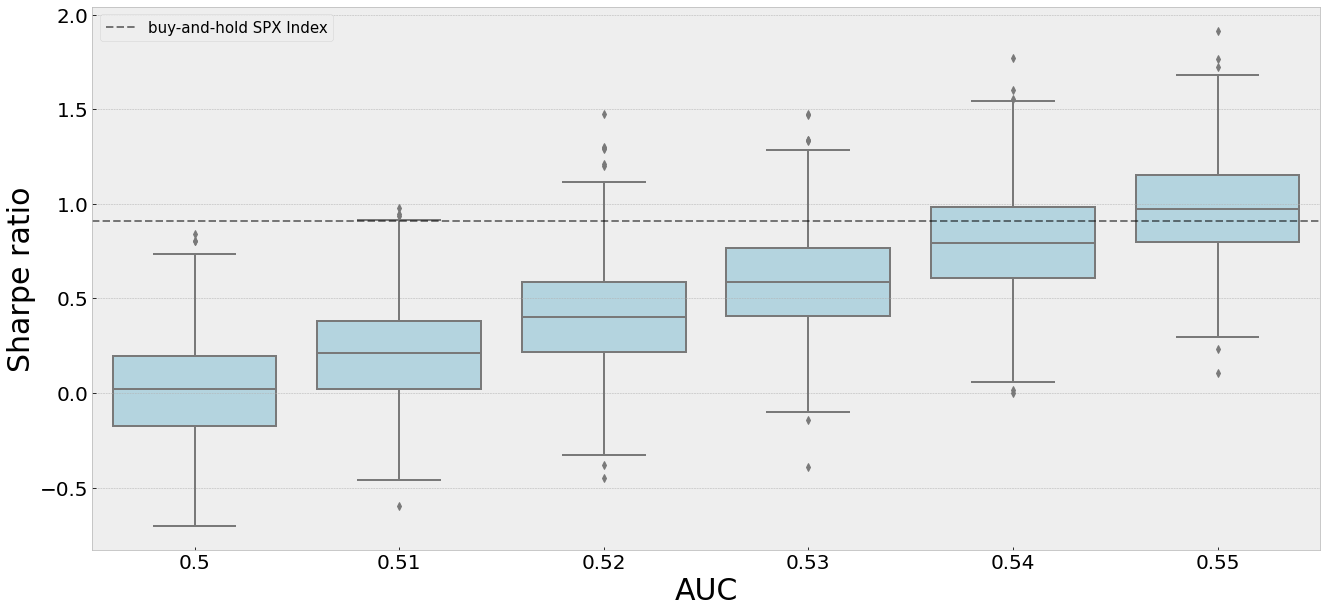

In [33]:
display(Markdown("### 1.3) Sharpe ratio distirbution for simulated strategies with fixed AUC"))

fig, ax = plt.subplots(figsize=(22,10))
sns.boxplot(x="auc", y='sharpe ratio',data=out_simu_df, ax=ax, color='lightblue');
ax.set_ylabel("Sharpe ratio", fontsize=30);
ax.set_xlabel("AUC", fontsize=30);
ax.axhline(y=0.91, color='k', linestyle='--', alpha=0.5, label="buy-and-hold SPX Index");
ax.tick_params(axis="x", labelsize=20);
ax.tick_params(axis="y", labelsize=20);
ax.legend(loc="best",fontsize=15);
fig.savefig('img/boxplot_simu_sr_known_auc.png')

In [ ]:
tot_time = time() - init
tot_time = tot_time / 60
print("notebook time = {:.3f} (minutes)".format(tot_time))